# <span style = "font-weight:bold;">Cohort, RFM 이커머스</span>
> <span style = "font-weight:bold;font-size:1.3em">목차</span>
>1. 사용 라이브러리
>2. 데이터 전처리 탐색 및 전처리
>3. Cohort 분석
>4. RFM 분석
>5. RFM 군집 나누기
>6. 지역별 차트 작성, 어디가 주목할 지역인가?
>7. 장바구니 분석
>8. 마케팅  전략

> <span style = "font-weight:bold;font-size:1.3em">사용 데이터</span>
>- Onlinesales_info.csv : 온라인거래와 관련된 정보
>- Customer_info.csv : 고객과 관련된 정보
>- Discount_info.csv : 할인과 관련된 정보
>- Marketing_info.csv : 마케팅비용과 관련된 정보
>- Tax_info.csv : 세금과 관련된 정보

> <span style = "font-weight:bold;font-size:1.3em">분석 요약</span>

## <span style = "">1. 사용 라이브러리</span>
><span style="font-style:italic; font-weight:bold;">기본</span>
> - pandas
> - numpy
> - maplotlib
> - seaborn
> - datetime
> - scipy

> <span style="font-weight:bold;font-style:italic;">Machine Learning</span>
> - KMeans

><span style="font-weight:bold;font-style:italic;">선택사항</span>
>- warnings

><span style="font-weight:bold;font-style:italic;">장바구니 분석</span>
>- apriori
>- association_rules
>-  TransactionEncoder

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['font.family']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

import datetime as dt

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.cluster import KMeans
import scipy.stats as sp

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

## 2. 데이터 전처리
><span style="font-weight:bold; font-style:italic;">순서</span>

>(1) 데이터 불러오기

>(2) 데이터 결합
>- "Onlinesales_info.csv", "Customer_info.csv" <고객ID> 기준 merge
>- "Tax_info.csv" <제품카테고리> 기준 추가 merge
>- merge 과정에서 결측치 발생, 컬럼의 변화 여부 확인

>(3) Feature Engineering
> - 총 거래금액 = 평균금액 * 수량( 1 + 세금 ) + 배송료

>(4) CSV 저장
>- "total_information.csv"

In [2]:
# (1) 데이터 확인
Onlinesales_info = pd.read_csv('../origin/Onlinesales_info.csv')
Customer_info = pd.read_csv('../origin/Customer_info.csv')
Tax_info = pd.read_csv('../origin/Tax_info.csv')
Marketing_info = pd.read_csv('../origin/Marketing_info.csv')
Discount_info = pd.read_csv('../origin/Discount_info.csv')

In [3]:
Customer_info.head()

,고객ID,성별,고객지역,가입기간
0,USER_1358,남,Chicago,12
1,USER_0190,남,California,43
2,USER_0066,남,Chicago,33
3,USER_0345,여,California,30
4,USER_0683,남,California,49


In [4]:
# (2) 데이터 결합
first_merge = pd.merge(Onlinesales_info, Customer_info, on = '고객ID', how = 'outer')
total_information = pd.merge(first_merge, Tax_info, on = '제품카테고리', how = 'outer')
# display(first_merge.isnull().sum(), first_merge.shape)
# display(total_inforamtion.isnull().sum(), total_inforamtion.shape)

In [5]:
def col_list(target, feature): # merge 과정에서 컬럼의 누락 등이 발생했는지 확인
    # print(target)
    for i in list(feature.columns):
        target.append(i)
    target_list = list(set(target))
    return target_list

def check_col(list1, list2):
    list1.sort()
    list2.sort()
    print(list1==list2)
check_list = []
check_list = col_list(check_list, Onlinesales_info)
check_list = col_list(check_list, Customer_info)
check_list = col_list(check_list, Tax_info)

check_col(check_list, list(total_information.columns))

True


In [6]:
# (3) Feature Engineering
total_information['Total_Purchase_Amount'] = total_information['평균금액']*total_information['수량']*(1+total_information['GST']) + total_information['배송료']
# display(total_information, total_information.isnull().sum(), total_information.info())

# (4) CSV 저장
total_information.to_csv('./preprocessing/total_information.csv', index=False)
total_information = pd.read_csv('./preprocessing/total_information.csv')
# display(total_information, total_information.isnull().sum(), total_information.info())

## 3. Cohort 분석
><span style="font-weight:bold; font-style:italic;">순서</span>

> (1) CSV 생성
> - cohort.csv(=단위 군집에 대한 고객 숫자, 거래 금액 정보)
> - is_back(=단위 군집의 재방문율 변화)
> - co_purchase(=단위 군집의 총거래금액 변화)

>(2) 클래스 및 함수 정의

>(3) Cohort 그래프 분석
> - is_back 그래프 분석

>(4) 코호트 군집 분석, Feature Engineering
> - < is_back_up_down 컬럼 > cohort 단위 군집의 "직전 월 대비 재방문율 증가 횟수"과 "직전 월 대비 재방문율 감소 횟수"의 차이
> - < co_purchase_up_down 컬럼 > cohort 단위 군집의 "직전 월 대비 총거래금액 증가 횟수"과 "직전 월 대비 총거래금액 감소 횟수"의 차이

> (5) 분석 - 마케팅 비용과 코호트 군집 간의 상관관계 분석

## 4. RFM 분석
> (1) RFM 데이터프레임 생성
>- Recency, Frequency, Monetary 컬럼

> (2) Recency, Frequency, Monetary 등급 나누기
> - zscore를 기반으로 구간 내 이상치 최소화
> - Frequency, Monetary의 경우 값의 분포가 매우 넓기 때문에 이상치 최소화를 위해서는 점수가 가장 높은 4등급에 적은 데이터가 할당된다.

> (3) 최종 정보를 'rfm_total_score.csv'로 저장


### (1) RFM 데이터프레임 생성

In [7]:
def z_score(df, check_col): # 이상치 분석 및 제거
    a = pd.DataFrame({'z':[]})
    df_z = df.copy()
    a['z'] = sp.zscore(df[check_col])
    df_z['z'] = a['z']
    df_z = df_z[df_z['z']<3]
    df_z = df_z[df_z['z']>-3]
    df_z.drop('z', axis=1, inplace = True)
    return df_z

total_information = pd.read_csv('./preprocessing/total_information.csv')
total_information_z = z_score(total_information, 'Total_Purchase_Amount')
total_information_z.to_csv('./preprocessing/total_information_z.csv', index=False)
total_information_z = pd.read_csv('./preprocessing/total_information_z.csv')
total_information_z

total_information_z = pd.read_csv('./preprocessing/total_information_z.csv')
total_information_z

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,Total_Purchase_Amount
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,175.5810
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,Chicago,12,0.10,175.5810
2,USER_1358,Transaction_0013,2019-01-01,Product_0983,Nest-USA,2,122.77,6.50,Not Used,남,Chicago,12,0.10,276.5940
3,USER_1358,Transaction_0015,2019-01-01,Product_0984,Nest-USA,1,81.50,6.50,Clicked,남,Chicago,12,0.10,96.1500
4,USER_1358,Transaction_0016,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Clicked,남,Chicago,12,0.10,175.5810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52417,USER_0442,Transaction_7918,2019-05-04,Product_0850,More Bags,5,17.59,18.12,Clicked,여,California,13,0.18,121.9010
52418,USER_0557,Transaction_7940,2019-05-04,Product_0850,More Bags,1,17.59,6.00,Not Used,남,California,36,0.18,26.7562
52419,USER_1374,Transaction_8818,2019-05-19,Product_0850,More Bags,1,21.99,6.00,Used,여,Chicago,27,0.18,31.9482
52420,USER_0994,Transaction_9049,2019-05-22,Product_0850,More Bags,1,17.59,51.99,Used,여,New York,46,0.18,72.7462


In [8]:
def RFM_Setting(df, customer_col, period_col, transaction_col, monetary_col):
    df[period_col] = pd.to_datetime(df[period_col])
    last_date = df[period_col].max() # 데이터 내에서 가장 마지막 날짜와 얼마나 가까운지를 기준으로 recency를 구한다.
    recency_data = df.groupby(customer_col, as_index=False)[period_col].max() # recency
    recency_data['Recency'] = (last_date- recency_data[period_col]).dt.days
    
    frequency_data = df.groupby(customer_col, as_index=False)[transaction_col].count()# frequency
    frequency_data.rename(columns={transaction_col:'Frequency'}, inplace = True)
    
    monetary_data = df.groupby(customer_col, as_index=False)[monetary_col].sum() # monetary
    monetary_data.rename(columns = {monetary_col:'Monetary'}, inplace=True)
    
    rfm_df = pd.merge(recency_data, frequency_data, on=customer_col)
    rfm_df = pd.merge(rfm_df, monetary_data, on=customer_col)
    rfm_df.rename(columns={'거래날짜':'last_ord_date'}, inplace=True)
    return rfm_df

rfm_df = RFM_Setting(df=total_information_z, customer_col='고객ID', period_col='거래날짜', transaction_col='거래ID', monetary_col='Total_Purchase_Amount')
rfm_df

,고객ID,last_ord_date,Recency,Frequency,Monetary
0,USER_0000,2019-09-15,107,2,185.6882
1,USER_0001,2019-11-02,59,55,6295.6076
2,USER_0002,2019-10-19,73,23,1842.8708
3,USER_0003,2019-12-14,17,17,1636.2142
4,USER_0004,2019-09-15,107,36,2231.7198
...,...,...,...,...,...
1463,USER_1463,2019-04-05,270,7,873.8902
1464,USER_1464,2019-10-05,87,40,3272.6406
1465,USER_1465,2019-06-20,194,8,171.0864
1466,USER_1466,2019-10-23,69,1,333.8000


### (2) Recency, Frequency, Monetary 등급 나누기

Recency의 백분위수 : 55.0 131.0 220.0
Frequency의 백분위수 : 12.0 33.0 114.0
Monetary의 백분위수 : 1014.63536 2796.8686199999997 11252.289644999999


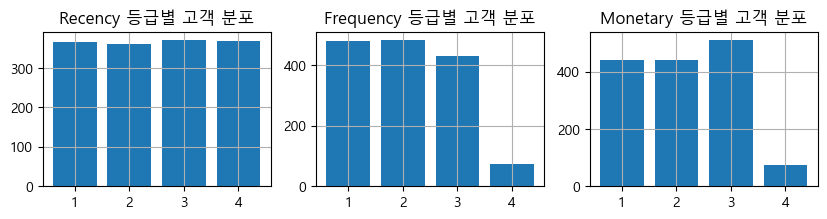

In [9]:
def grade_setting(x):
    if x <= n1:
        return 1
    elif x > n1 and x <= n2:
        return 2
    elif x > n2 and x <= n3:
        return 3
    else:
        return 4

def grade_setting_reverse(x): # Recency는 값이 작을수록 높은 점수를 부여해야 한다.
    if x <= n1:
        return 4
    elif x > n1 and x <= n2:
        return 3
    elif x > n2 and x <= n3:
        return 2
    else:
        return 1

n1, n2, n3 = np.percentile(rfm_df['Recency'], [25, 50, 75])
print('Recency의 백분위수 :',n1, n2, n3)
rfm_df['Recency_Grade'] = rfm_df['Recency'].apply(grade_setting_reverse)
rg = rfm_df['Recency_Grade'].value_counts().to_frame().sort_values(by='Recency_Grade').reset_index()

n1, n2, n3 = np.percentile(rfm_df['Frequency'], [30, 65, 95])
# n1, n2, n3 = np.percentile(rfm_df['Frequency'], [25, 50, 75])
print('Frequency의 백분위수 :',n1, n2, n3)
rfm_df['Frequency_Grade'] = rfm_df['Frequency'].apply(grade_setting)
fg = rfm_df['Frequency_Grade'].value_counts().to_frame().sort_values(by='Frequency_Grade').reset_index()

n1, n2, n3 = np.percentile(rfm_df['Monetary'], [30, 60, 95])
print('Monetary의 백분위수 :',n1, n2, n3)
rfm_df['Monetary_Grade'] = rfm_df['Monetary'].apply(grade_setting)
mg = rfm_df['Monetary_Grade'].value_counts().to_frame().sort_values(by='Monetary_Grade').reset_index()

plt.figure(figsize=(10,2))

plt.subplot(1,3,1)
plt.bar('Recency_Grade', 'count', data=rg)
plt.title('Recency 등급별 고객 분포')
plt.grid()
plt.subplot(1,3,2)
plt.bar('Frequency_Grade', 'count', data=fg)
plt.title('Frequency 등급별 고객 분포')
plt.grid()
plt.subplot(1,3,3)
plt.bar('Monetary_Grade', 'count', data=mg)
plt.title('Monetary 등급별 고객 분포')
plt.grid()
# plt.bar(rfm_df['Recency_Grade'].value_counts().to_frame().index(),rfm_df['Recency_Grade'].value_counts().to_frame()['count'])

Frequency_Grade
2    485
1    480
3    430
4     73
Name: count, dtype: int64

---------------------------------------------------------------------------------------------------- 
등급 1 : 이상치 데이터프레임


,Frequency


,Frequency


---------------------------------------------------------------------------------------------------- 
등급 2 : 이상치 데이터프레임


,Frequency


,Frequency


---------------------------------------------------------------------------------------------------- 
등급 3 : 이상치 데이터프레임


,Frequency


,Frequency


---------------------------------------------------------------------------------------------------- 
등급 4 : 이상치 데이터프레임


,Frequency
118,4.174651
563,3.129863
736,3.222546
1355,3.197269


,Frequency


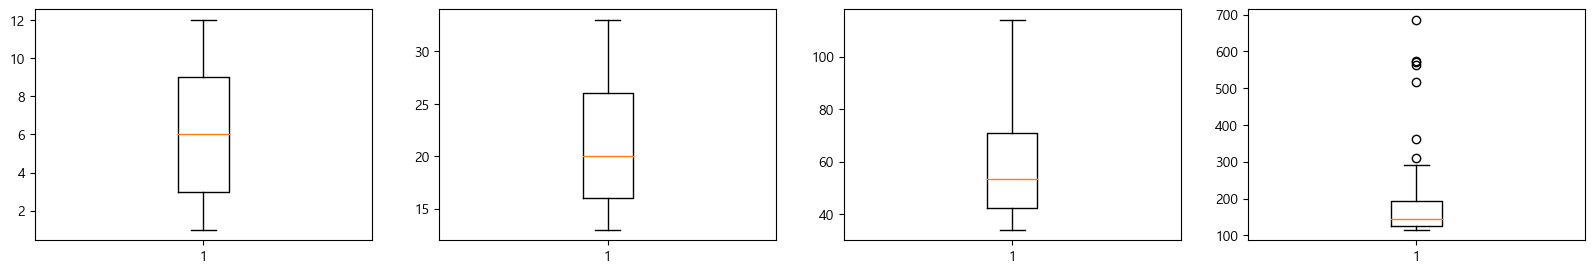

In [10]:
def RFM_abnormal(df, col, grade_col):
    display(df[grade_col].value_counts())
    plt.subplot(1,4,1)
    plt.boxplot(df.loc[df[grade_col]==1].sort_values(by=col)[col])
    z_check = sp.zscore(df.loc[df[grade_col]==1][col] ).to_frame()
    print('-'*100,'\n등급 1 : 이상치 데이터프레임')
    display(z_check.loc[z_check[col]>=3] )
    display(z_check.loc[z_check[col]<=-3] )
    
    plt.subplot(1,4,2)
    plt.boxplot(df.loc[df[grade_col]==2].sort_values(by=col)[col])
    z_check = sp.zscore(df.loc[df[grade_col]==2][col] ).to_frame()
    print('-'*100,'\n등급 2 : 이상치 데이터프레임')
    display(z_check.loc[z_check[col]>=3] )
    display(z_check.loc[z_check[col]<=-3] )
    
    plt.subplot(1,4,3)
    plt.boxplot(df.loc[df[grade_col]==3].sort_values(by=col)[col])
    z_check = sp.zscore(df.loc[df[grade_col]==3][col] ).to_frame()
    print('-'*100,'\n등급 3 : 이상치 데이터프레임')
    display(z_check.loc[z_check[col]>=3] )
    display(z_check.loc[z_check[col]<=-3] )
    
    plt.subplot(1,4,4)
    plt.boxplot(df.loc[df[grade_col]==4].sort_values(by=col)[col])
    z_check = sp.zscore(df.loc[df[grade_col]==4][col] ).to_frame()
    print('-'*100,'\n등급 4 : 이상치 데이터프레임')
    display(z_check.loc[z_check[col]>=3] )
    display(z_check.loc[z_check[col]<=-3] )

plt.figure(figsize=(20,3))
# RFM_abnormal(rfm_df, 'Recency', 'Recency_Grade')
RFM_abnormal(rfm_df, 'Frequency', 'Frequency_Grade')
# RFM_abnormal(rfm_df, 'Monetary', 'Monetary_Grade')

In [11]:
rfm_df

,고객ID,last_ord_date,Recency,Frequency,Monetary,Recency_Grade,Frequency_Grade,Monetary_Grade
0,USER_0000,2019-09-15,107,2,185.6882,3,1,1
1,USER_0001,2019-11-02,59,55,6295.6076,3,3,3
2,USER_0002,2019-10-19,73,23,1842.8708,3,2,2
3,USER_0003,2019-12-14,17,17,1636.2142,4,2,2
4,USER_0004,2019-09-15,107,36,2231.7198,3,3,2
...,...,...,...,...,...,...,...,...
1463,USER_1463,2019-04-05,270,7,873.8902,1,1,1
1464,USER_1464,2019-10-05,87,40,3272.6406,3,3,3
1465,USER_1465,2019-06-20,194,8,171.0864,2,1,1
1466,USER_1466,2019-10-23,69,1,333.8000,3,1,1


## 5. RFM 군집 나누기
>1) KMeans 활용 군집 묶기
>2) KMeans 군집의 의미 분석, rfm_kmean_merge.csv로 저장
>3) 차트 작성
>4) 지역별 차트 작성, 어디가 주목할 지역인가?

### (1) KMeans 활용 군집 묶기

In [12]:
rfm_analysis = rfm_df.copy()
rfm_analysis.drop(['last_ord_date', 'Recency', 'Frequency', 'Monetary',], axis=1, inplace=True)

In [13]:
class clustering:
    def __init__(self, df):    
        self.df = df

    def elbow_method(self, ks, n): 
        inertias=[]
        for k in ks:
            model = KMeans(n_clusters = k, n_init = n)
            %time model.fit(self.df)
            inertias.append(model.inertia_)
            print('n_cluster:{}, inertia:{}'.format(k,model.inertia_)) 
            print('---------') # n_cluster, inertia 결과 출력
        plt.figure(figsize=(5,5))
        plt.plot(ks,inertias,'-o') # '-o'는 실선과 원을 같이 시각화
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.xticks(ks)
        plt.tight_layout()
        plt.grid()
        plt.show()
        
    def kmeans_cluter(self, cluster_num, n, rs):
        
        model = KMeans(n_clusters = cluster_num, 
                       n_init = n, 
                       random_state=rs)
        model.fit(self.df)
        self.kmean = model.predict(self.df)
        self.df['k_group'] = self.kmean

In [14]:
rfm_df_kmeans = clustering(rfm_analysis.copy())
rfm_df_kmeans.df.drop('고객ID', axis=1, inplace=True)

CPU times: total: 891 ms
Wall time: 495 ms
n_cluster:3, inertia:1622.540991515377
---------
CPU times: total: 1.2 s
Wall time: 349 ms
n_cluster:4, inertia:1076.5098286029104
---------
CPU times: total: 1.06 s
Wall time: 331 ms
n_cluster:5, inertia:896.6888367960041
---------
CPU times: total: 1.03 s
Wall time: 331 ms
n_cluster:6, inertia:756.9982081464412
---------
CPU times: total: 1.33 s
Wall time: 335 ms
n_cluster:7, inertia:679.0997504479391
---------
CPU times: total: 1.27 s
Wall time: 342 ms
n_cluster:8, inertia:603.220666621573
---------
CPU times: total: 1.28 s
Wall time: 364 ms
n_cluster:9, inertia:516.8610520744661
---------


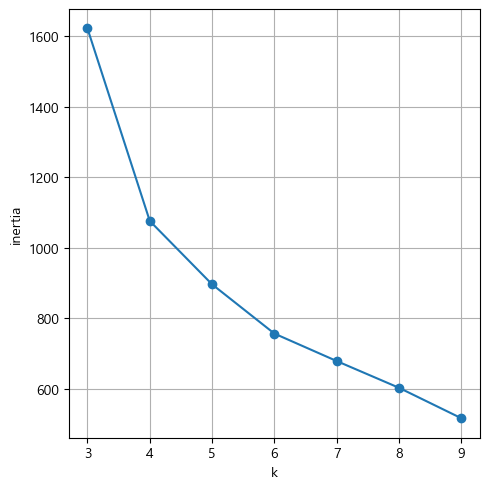

In [15]:
rfm_df_kmeans.elbow_method(ks=range(3,10), 
                           n=10) # 몇 개의 군집으로 묶는 것이 가장 합리적인지 확인

In [16]:
rfm_df_kmeans.kmeans_cluter(cluster_num=4, 
                            n=10, 
                            rs=50)
rfm_kmean = rfm_df_kmeans.df

In [17]:
rfm_kmean_merge = rfm_analysis.copy().reset_index()
rfm_kmean_merge = pd.merge(rfm_kmean_merge, rfm_kmean.reset_index(), 
                           on=['index','Recency_Grade', 'Frequency_Grade','Monetary_Grade'])
rfm_kmean_merge.drop('index', axis=1, inplace=True)

In [18]:
rfm_kmean_merge.rename(columns={'k_group':'Customer_Segment'},inplace=True)
# rfm_kmean_merge.to_csv('./preprocessing/rfm_kmean_merge.csv',index=False)
pd.read_csv('./preprocessing/rfm_kmean_merge.csv')
rfm_kmean_merge = pd.read_csv('./preprocessing/rfm_kmean_merge.csv')

### (2) KMeans 군집의 의미 분석, rfm_kmean_merge.csv로 저장

In [19]:
# rfm_kmean_Recency = pd.crosstab(rfm_kmean_merge['Customer_Segment'], rfm_kmean_merge['Recency_Grade'], margins=True)
# rfm_kmean_Recency = pd.crosstab(rfm_kmean_merge['Customer_Segment'], rfm_kmean_merge['Recency_Grade'], margins=True)
# rfm_kmean_Recency['0 비율'] = np.round( ( rfm_kmean_Recency[1]/rfm_kmean_Recency['All'] )*100, 2 )
# rfm_kmean_Recency['1 비율'] = np.round( ( rfm_kmean_Recency[2]/rfm_kmean_Recency['All'] )*100, 2 )
# rfm_kmean_Recency['2 비율'] = np.round( ( rfm_kmean_Recency[3]/rfm_kmean_Recency['All'] )*100, 2 )
# rfm_kmean_Recency['3 비율'] = np.round( ( rfm_kmean_Recency[4]/rfm_kmean_Recency['All'] )*100, 2 )

# rfm_kmean_Frequency = pd.crosstab(rfm_kmean_merge['Customer_Segment'], rfm_kmean_merge['Frequency_Grade'], margins=True)
# rfm_kmean_Frequency['0 비율'] = np.round( ( rfm_kmean_Frequency[1]/rfm_kmean_Frequency['All'] )*100, 2 )
# rfm_kmean_Frequency['1 비율'] = np.round( ( rfm_kmean_Frequency[2]/rfm_kmean_Frequency['All'] )*100, 2 )
# rfm_kmean_Frequency['2 비율'] = np.round( ( rfm_kmean_Frequency[3]/rfm_kmean_Frequency['All'] )*100, 2 )
# rfm_kmean_Frequency['3 비율'] = np.round( ( rfm_kmean_Frequency[4]/rfm_kmean_Frequency['All'] )*100, 2 )

# rfm_kmean_Monetary = pd.crosstab(rfm_kmean_merge['Customer_Segment'], rfm_kmean_merge['Monetary_Grade'], margins=True)
# rfm_kmean_Monetary['0 비율'] = np.round( ( rfm_kmean_Monetary[1]/rfm_kmean_Monetary['All'] )*100, 2 )
# rfm_kmean_Monetary['1 비율'] = np.round( ( rfm_kmean_Monetary[2]/rfm_kmean_Monetary['All'] )*100, 2 )
# rfm_kmean_Monetary['2 비율'] = np.round( ( rfm_kmean_Monetary[3]/rfm_kmean_Monetary['All'] )*100, 2 )
# rfm_kmean_Monetary['3 비율'] = np.round( ( rfm_kmean_Monetary[4]/rfm_kmean_Monetary['All'] )*100, 2 )

# rfm_kmean_Recency.to_csv('./preprocessing/rfm_kmean_Recency.csv', index=False)
rfm_kmean_Recency = pd.read_csv('./preprocessing/rfm_kmean_Recency.csv')

# rfm_kmean_Frequency.to_csv('./preprocessing/rfm_kmean_Frequency.csv', index=False)
rfm_kmean_Frequency = pd.read_csv('./preprocessing/rfm_kmean_Frequency.csv')

# rfm_kmean_Monetary.to_csv('./preprocessing/rfm_kmean_Monetary.csv', index=False)
rfm_kmean_Monetary = pd.read_csv('./preprocessing/rfm_kmean_Monetary.csv')

display(rfm_kmean_Recency), display(rfm_kmean_Frequency), display(rfm_kmean_Monetary)

,1,2,3,4,All,0 비율,1 비율,2 비율,3 비율
0,254,255,0,0,509,49.90,50.10,0.00,0.00
1,0,0,181,219,400,0.00,0.00,45.25,54.75
2,112,106,0,0,218,51.38,48.62,0.00,0.00
3,0,0,191,150,341,0.00,0.00,56.01,43.99
4,366,361,372,369,1468,24.93,24.59,25.34,25.14


,1,2,3,4,All,0 비율,1 비율,2 비율,3 비율
0,294,215,0,0,509,57.76,42.24,0.00,0.00
1,0,78,264,58,400,0.00,19.50,66.00,14.50
2,0,37,166,15,218,0.00,16.97,76.15,6.88
3,186,155,0,0,341,54.55,45.45,0.00,0.00
4,480,485,430,73,1468,32.70,33.04,29.29,4.97


,1,2,3,4,All,0 비율,1 비율,2 비율,3 비율
0,284,224,1,0,509,55.80,44.01,0.20,0.00
1,0,21,316,63,400,0.00,5.25,79.00,15.75
2,0,11,196,11,218,0.00,5.05,89.91,5.05
3,157,184,0,0,341,46.04,53.96,0.00,0.00
4,441,440,513,74,1468,30.04,29.97,34.95,5.04


(None, None, None)

In [20]:
rfm_kmean_merge['Customer_Segment'] = rfm_kmean_merge['Customer_Segment'].map({0:'미관심 고객', 
                                                                               1:'VIP 고객', 
                                                                               2:'수면 고객', 
                                                                               3:'신규 고객'})
# rfm_kmean_merge.to_csv('./preprocessing/rfm_kmean_merge_segmentation.csv',index=False)

In [21]:
rfm_kmean_merge = pd.read_csv('./preprocessing/rfm_kmean_merge_segmentation.csv')
rfm_kmean_merge

,고객ID,Recency_Grade,Frequency_Grade,Monetary_Grade,Customer_Segment
0,USER_0000,3,1,1,신규 고객
1,USER_0001,3,3,3,VIP 고객
2,USER_0002,3,2,2,신규 고객
3,USER_0003,4,2,2,신규 고객
4,USER_0004,3,3,2,VIP 고객
...,...,...,...,...,...
1463,USER_1463,1,1,1,미관심 고객
1464,USER_1464,3,3,3,VIP 고객
1465,USER_1465,2,1,1,미관심 고객
1466,USER_1466,3,1,1,신규 고객


> 군집 0 ( = 미관심 고객 )
>- Recency 가장 낮다, Frequency 가장 낮다, Monetary 가장 낮다

> 군집 1 ( = VIP 고객 )
>- Recency 가장 높다, Frequency 가장 높다, Monetary 가장 높다

> 군집 2 ( = 수면 고객, 과거에 활발한 이용 )
>- Recency 낮은 편, Frequency 높은 편, Monetary 높은 편


> 군집 3 ( = 신규 고객 )
>- Recency 높은 편, Frequency 낮은 편, Monetary 낮은 편

### (3) 차트 작성, 다른 차트와 비교하며 인사이트 도출

,count
Customer_Segment,
미관심 고객,509
VIP 고객,400
신규 고객,341
수면 고객,218


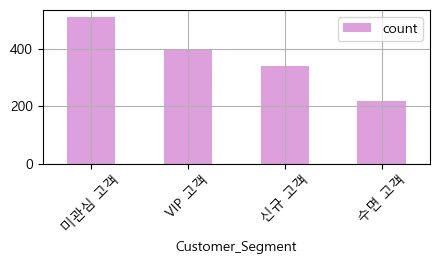

In [22]:
display(rfm_kmean_merge['Customer_Segment'].value_counts().to_frame())
rfm_kmean_merge['Customer_Segment'].value_counts().to_frame().plot(kind='bar', figsize=(5,2), color = 'plum')
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [23]:
display(rfm_kmean_merge['Customer_Segment'].value_counts().to_frame().index)
display(rfm_kmean_merge['Customer_Segment'].value_counts().to_frame().values)

Index(['미관심 고객', 'VIP 고객', '신규 고객', '수면 고객'], dtype='object', name='Customer_Segment')

array([[509],
       [400],
       [341],
       [218]], dtype=int64)

,고객분류,숫자,고객비율
0,미관심 고객,509,34.67
1,VIP 고객,400,27.25
2,신규 고객,341,23.23
3,수면 고객,218,14.85


None

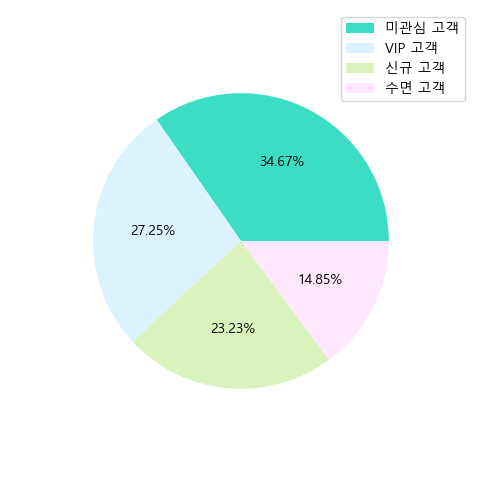

In [24]:
rfm_pie_graph = rfm_kmean_merge['Customer_Segment'].value_counts().to_frame().reset_index()
rfm_pie_graph.rename({'Customer_Segment' : '고객분류',
                      'count':'숫자'}, axis=1, inplace =True)
rfm_pie_graph['고객비율'] = round(rfm_pie_graph['숫자']/rfm_pie_graph['숫자'].sum()*100,2)
display(rfm_pie_graph)
display(rfm_pie_graph.to_excel('../cal/temp.xlsx'))

plt.figure(figsize=(6,6))
plt.pie(x=rfm_pie_graph['고객비율'].values,
        colors = ['#3CDDC5', '#DBF2FF', '#DAF3BD', '#FFE7FF'],
        autopct='%.2f%%',
        radius=0.8)
plt.legend(labels=rfm_pie_graph['고객분류'].values)
plt.show()

### (1) Cohort CSV 생성

In [25]:
def First_OrderMonth(df, ref_month, customer_col): # 첫 주문월과 구매 주기 컬럼 추가
    df[ref_month] = pd.to_datetime(df[ref_month])
    df['OrderCycle'] = df['거래날짜'].dt.strftime('%Y-%m')
    first_order = df.groupby(customer_col)[ref_month].min()
    first_order = first_order.dt.strftime('%Y-%m')
    df.set_index(customer_col, inplace = True)
    df['First_Order'] = first_order
    df.reset_index(inplace=True)
    return df

def CohortPeriod(df, first_order, order_cycle): # 코호트 주기 계산
    temp = []
    for i in range(df.shape[0]):
        f_first_order = pd.to_datetime(df[first_order][i]).to_period('M')
        f_order_cycle = pd.to_datetime(df[order_cycle][i]).to_period('M')
        month_diff = (f_order_cycle-f_first_order).n
        temp.append(month_diff)
    df['CohortPeriod'] = temp
    return df

def CohrotFrame(df, first_order, target_col, cohort_period, ratio=None): # pandas unstack 진행
    df = df.set_index([first_order, cohort_period])
    df = df[target_col].unstack(1)
    if ratio is not None:
        df = df.div(df[0], axis=0)
    return df


In [26]:
cohort = total_information.drop([ '수량', '제품카테고리', '평균금액', '배송료', '쿠폰상태', '성별', '고객지역', '가입기간', 'GST'], axis=1) # 필요 없는 컬럼 삭제
cohort = pd.merge(rfm_kmean_merge, total_information,
                  on='고객ID', how='left')

cohort = First_OrderMonth(df=cohort, 
                          ref_month='거래날짜', 
                          customer_col='고객ID')
cohort_new = cohort.loc[cohort['Customer_Segment']=='신규 고객']
cohort_vip = cohort.loc[cohort['Customer_Segment']=='VIP 고객']
cohort_sleep = cohort.loc[cohort['Customer_Segment']=='수면 고객']
cohort_indifference = cohort.loc[cohort['Customer_Segment']=='미관심 고객']

# 예시) 첫 주문월이 1월인 고객 중에서 2월에 다시 방문한 고객의 숫자
co = cohort.groupby(['First_Order', 'OrderCycle'])['고객ID'].nunique()
co_vip = cohort_vip.groupby(['First_Order', 'OrderCycle'])['고객ID'].nunique()

co = co.reset_index()
co_vip = co_vip.reset_index()

co = CohortPeriod(df=co, first_order= 'First_Order', order_cycle='OrderCycle') # 코호트 주기 계산
co.rename({'고객ID':'TotalUsers'}, axis = 1,inplace=True)

co_vip = CohortPeriod(df=co_vip, first_order= 'First_Order', order_cycle='OrderCycle') # 코호트 주기 계산
co_vip.rename({'고객ID':'TotalUsers'}, axis = 1,inplace=True)

co.to_csv('./preprocessing/cohort.csv', index=False) # 코호트 csv 저장
co = pd.read_csv('./preprocessing/cohort.csv')

co_vip.to_csv('./preprocessing/cohort_vip.csv', index=False) # 코호트 csv 저장
co_vip = pd.read_csv('./preprocessing/cohort_vip.csv')

,0,1,2,3,4,5,6,7,8,9,10,11
1,1.0,0.060465,0.111628,0.158140,0.106977,0.204651,0.162791,0.218605,0.106977,0.130233,0.093023,0.15814
2,1.0,0.072917,0.093750,0.166667,0.177083,0.229167,0.197917,0.156250,0.125000,0.114583,0.166667,NaN
3,1.0,0.101695,0.197740,0.141243,0.180791,0.186441,0.124294,0.124294,0.084746,0.107345,NaN,NaN
4,1.0,0.085890,0.147239,0.147239,0.110429,0.092025,0.061350,0.098160,0.073620,NaN,NaN,NaN
5,1.0,0.107143,0.080357,0.116071,0.089286,0.116071,0.125000,0.071429,NaN,NaN,NaN,NaN
6,1.0,0.145985,0.160584,0.087591,0.080292,0.102190,0.080292,NaN,NaN,NaN,NaN,NaN
7,1.0,0.138298,0.042553,0.063830,0.117021,0.095745,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.103704,0.111111,0.074074,0.059259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.076923,0.038462,0.025641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.0,0.068966,0.045977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10,11
1,1.0,0.157895,0.263158,0.298246,0.175439,0.473684,0.421053,0.508772,0.385965,0.438596,0.350877,0.473684
2,1.0,0.138889,0.111111,0.250000,0.250000,0.361111,0.305556,0.333333,0.222222,0.277778,0.388889,NaN
3,1.0,0.137255,0.333333,0.274510,0.254902,0.431373,0.313725,0.392157,0.254902,0.294118,NaN,NaN
4,1.0,0.200000,0.257143,0.257143,0.200000,0.371429,0.200000,0.400000,0.285714,NaN,NaN,NaN
5,1.0,0.178571,0.107143,0.250000,0.250000,0.357143,0.392857,0.178571,NaN,NaN,NaN,NaN
6,1.0,0.357143,0.392857,0.321429,0.178571,0.357143,0.250000,NaN,NaN,NaN,NaN,NaN
7,1.0,0.333333,0.266667,0.266667,0.400000,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.240000,0.320000,0.200000,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.125000,0.125000,0.041667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.0,0.029412,0.088235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'is_back_vip')

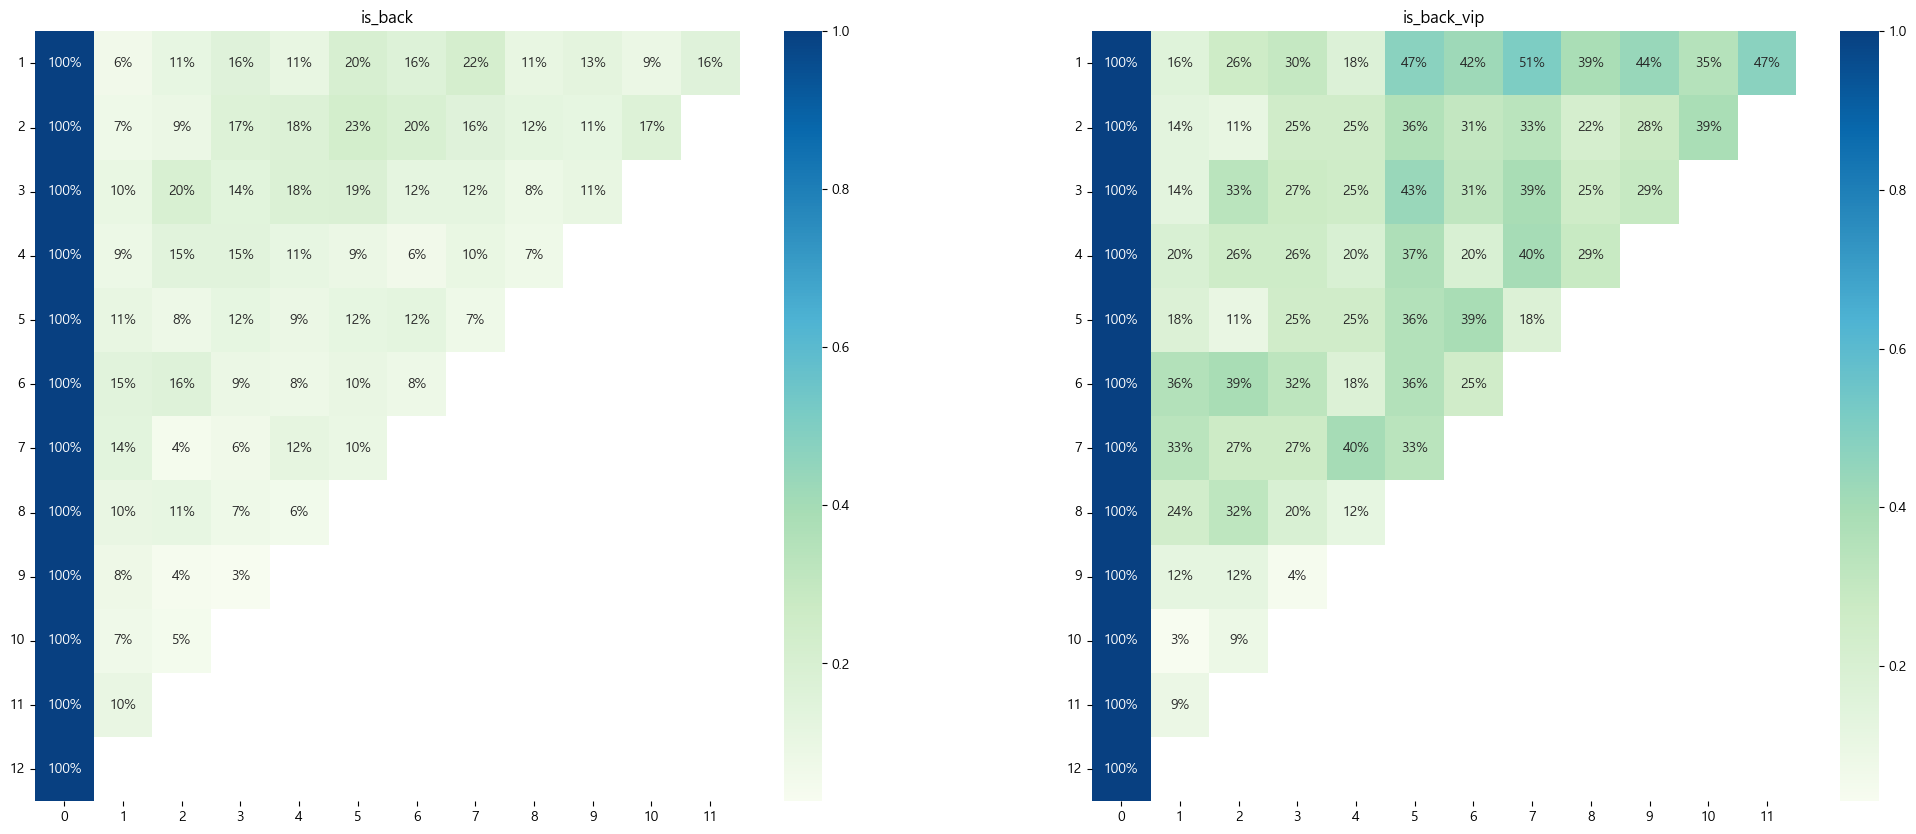

In [27]:
is_back= CohrotFrame(df = co, 
                     first_order = 'First_Order', 
                     target_col = 'TotalUsers', 
                     cohort_period = 'CohortPeriod', ratio = True)
is_back.to_csv('./preprocessing/is_back.csv', index=False)
is_back = pd.read_csv('./preprocessing/is_back.csv')
is_back.index = [1,2,3,4,5,6,7,8,9,10,11,12]
display(is_back)

plt.rcParams['figure.figsize'] = (25,10)
plt.subplot(1,2,1)
sns.heatmap(is_back, 
            annot=True,
            cmap = 'GnBu',
            fmt = '.0%')
plt.yticks(rotation=360)
plt.title('is_back')

is_back_vip = CohrotFrame(df = co_vip, 
                     first_order = 'First_Order', 
                     target_col = 'TotalUsers', 
                     cohort_period = 'CohortPeriod', ratio = True)
is_back_vip.to_csv('./preprocessing/is_back_vip.csv', index=False)
is_back_vip = pd.read_csv('./preprocessing/is_back_vip.csv')
is_back_vip.index = [1,2,3,4,5,6,7,8,9,10,11,12]
display(is_back_vip)

plt.rcParams['figure.figsize'] = (25,10)
plt.subplot(1,2,2)
sns.heatmap(is_back_vip, 
            annot=True,
            cmap = 'GnBu',
            fmt = '.0%')
plt.yticks(rotation=360)
plt.title('is_back_vip')

### (2) 클래스 및 함수 정의

In [28]:
class cohort_analysis: # chort_csv를 분석하기 위한 class
    def __init__(self, csv): # 생성자 메서드
        self.df = csv
                
    #################################### Cohort ##############################################
    def change_index_col_number(self, feature, month_colname): # 인덱스 이름 변경, 
        number_set = [i+1 for i in range(len(self.df.columns)) ] # 다루기 쉽도록 컬럼 이름을 0, 1, 2에서 1, 2, 3으로 변경
        self.df.columns = number_set
        self.df.index = list(feature[month_colname]) # 인덱스 이름들을 feature의 특정 컬럼값들로 변경

    def change_for_cohort_graph(self): # 코호트 그래프를 그리기 위해 데이터프레임 변형
        cohort_df_transpose = self.df.T
        cohort_df_new = cohort_df_transpose.copy()
        cohort_df_new.loc[:] = 0 # 0으로 채워진 컬럼 생성, 새로운 데이터프레임을 위한 초석
        for i in cohort_df_new.columns: # 2019-01 등이 컬럼명으로 바뀐 상태
            if i.month ==1: # 1월에 해당하는 데이터는 값을 모두 채운다.
                cohort_df_new[i].loc[:] = list( cohort_df_transpose[i][:] )
            else:
                cohort_df_new.loc[i.month: , i] = list( cohort_df_transpose[i])[: - i.month+1]
                # 2월이면 인덱스 2부터 끝까지 값을 채운다.
                # 2월이라고 생각하면 맨 마지막 값은 없으므로 [ : - (2+1) ] = [ : -1] 마지막에서 하나 빼고 읽는다.
        self.cohort_df_transpose = cohort_df_transpose
        self.cohort_df_new = cohort_df_new

    def cohort_graph(self, xlim = None, ylim = None, title = None):
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", # 짙은 파란색, 주황색, 초록색, 빨간색, 보라색, 갈색, 
                  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#ffbb78" ] # 분홍색, 회색, 녹색이 섞인 노란색, 청록색, 밝은 파란색. 밝은 주황색
        self.cohort_df_new.index = list(self.cohort_df_new.columns.astype(str))
        plt.figure(figsize=(20,5))
        for i in self.cohort_df_new.columns:
            if i.month ==1:
                plt.plot(self.cohort_df_new.index, self.cohort_df_new[i], marker='o', label = i, color =  colors[i.month-1])
            else: # 1월이 아닌 경우에는 시작점을 다르게 한다. 예를 들어 2월인 경우에는 두 번째부터 그래프를 그리도록 한다.
                plt.plot(self.cohort_df_new.index[i.month-1:], self.cohort_df_new[i][i.month-1:], marker='o', label = i, color =  colors[i.month-1])
        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None: 
            plt.ylim(ylim)
        if title is not None:
            plt.title(title)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()
    
    def cohort_graph_subplot(self, xlim=None, ylim=None, title = None):
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", # 짙은 파란색, 주황색, 초록색, 빨간색, 보라색, 갈색, 
                  "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#ffbb78" ] # 분홍색, 회색, 녹색이 섞인 노란색, 청록색, 밝은 파란색. 밝은 주황색
        self.cohort_df_new.index = list(self.cohort_df_new.columns.astype(str))
        plt.figure(figsize=(15,20))
        for i in self.cohort_df_new.columns:
            if i.month ==1:
                plt.subplot(6, 2, i.month)
                plt.plot(self.cohort_df_new.index, self.cohort_df_new[i], marker='o', label = i, color =  colors[i.month-1], linewidth = '1.1')
                if xlim is not None:
                    plt.xlim(xlim)
                if ylim is not None:
                    plt.ylim(ylim)
                if title is not None:
                    plt.title(title)
                plt.legend()
                plt.xticks(rotation=30)
                plt.grid()
            else:
                plt.subplot(6, 2, i.month)
                plt.plot(self.cohort_df_new.index[i.month-1:], self.cohort_df_new[i][i.month-1:], marker='o', label = i, color =  colors[i.month-1], linewidth = '1.1')
                if xlim is not None:
                    plt.xlim(xlim)
                if ylim is not None:
                    plt.ylim(ylim)
                   
                plt.legend()
                plt.xticks(rotation=30)
                plt.grid()
        
        plt.show()

def x_y_graph(df, x, y, how, title = None ): # x축, y축의 plot 그래프 그리기
    df[x] = df[x].astype(str)
    plt_func = getattr(plt, how, plt.plot)
    plt_func(x, y, data = df)
    if title is not None:
        plt.title(f"{title}\n{x} : {y}")
    else:
        plt.title(f"{x} : {y}")
    plt.xticks(rotation = 45)
    plt.grid()
    plt.legend()
    plt.show()

def to_month(df, x): # 특정 컬럼 데이터 형식을 월 형식으로 변경 후 문자형 타입으로 변형
    df[x] = pd.to_datetime(df[x])
    df[x] = df[x].dt.to_period('M')
    df[x] = df[x].astype(str)
    return df

class calendar_control: # 달력을 원하는 형태로 가공하기 위한 클래스
    def __init__(self, start_month, number, col_name):
        self.col_name = col_name
        self.df = pd.DataFrame({self.col_name: [] })
        self.start_month = start_month
        self.year, self.month = map(int, self.start_month.split('-')) 
        self.number = number

    def calendar_maker(self):
        month_list = []
        fin_list = []
        for i in range(self.month, self.number+1): # month를 원하는 만큼 채운다.
            month_list.append(i)
        for i in month_list: 
            fin_list.append(str(self.year) + '-' + str(i))
        self.df[self.col_name] = fin_list
        self.df[self.col_name] = pd.to_datetime(self.df[self.col_name]).dt.to_period('M')

cal = calendar_control('2019-01', 12, 'month') # 12월까지 달력을 생성
cal.calendar_maker()
cal_df = cal.df
# cal_df

### (3) Cohort 그래프 분석
- is_back 그래프 분석
- co_purchase 그래프 분석

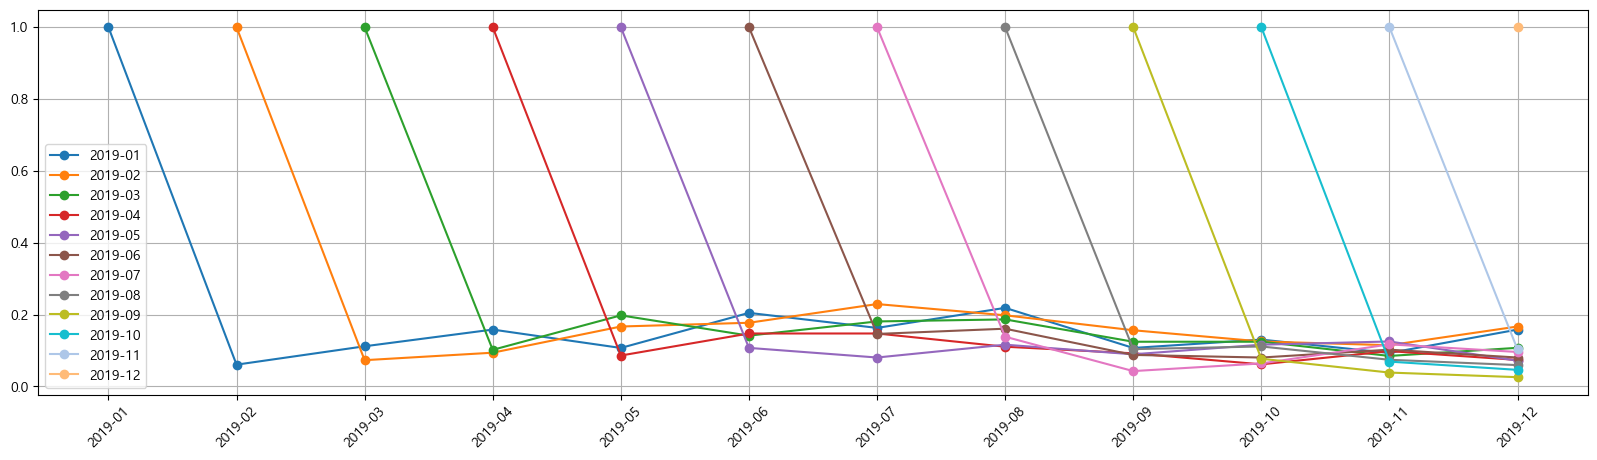

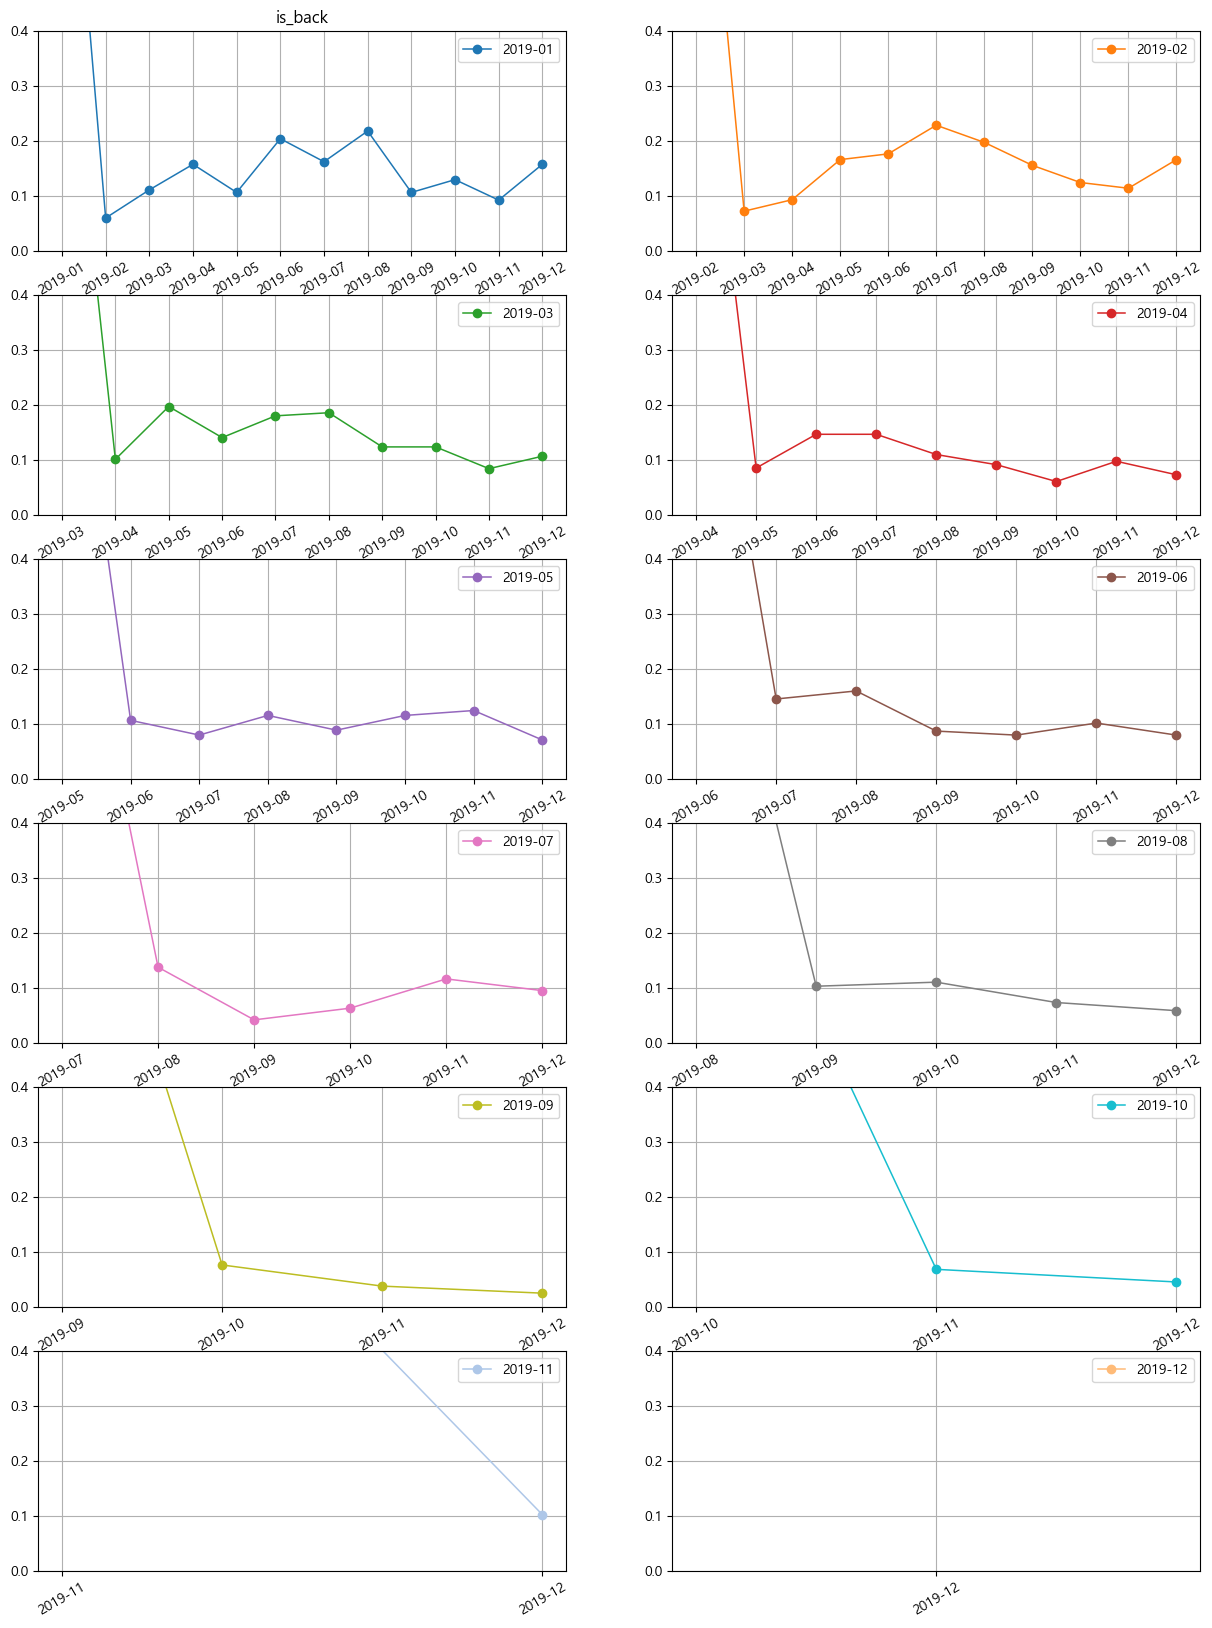

In [29]:
is_back = cohort_analysis(pd.read_csv('./preprocessing/is_back.csv') )
is_back.change_index_col_number(feature = cal_df, month_colname = 'month')

is_back.change_for_cohort_graph()

is_back.cohort_graph()
is_back.cohort_graph_subplot(title = 'is_back', xlim = None, ylim = [0, 0.4])

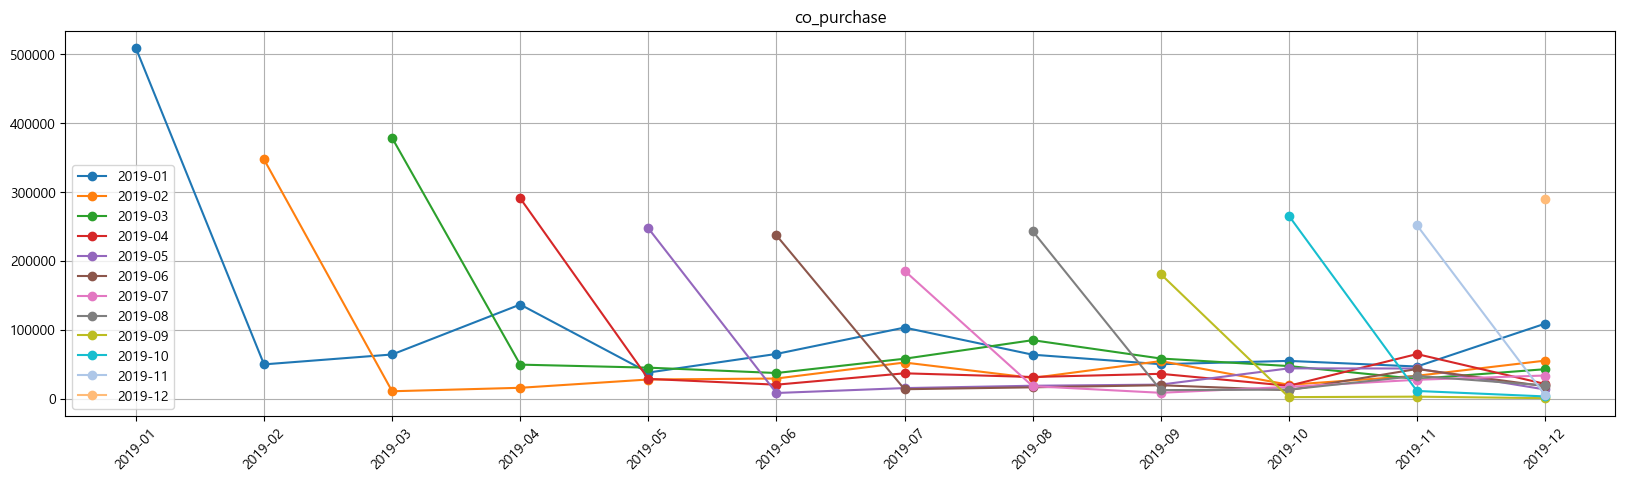

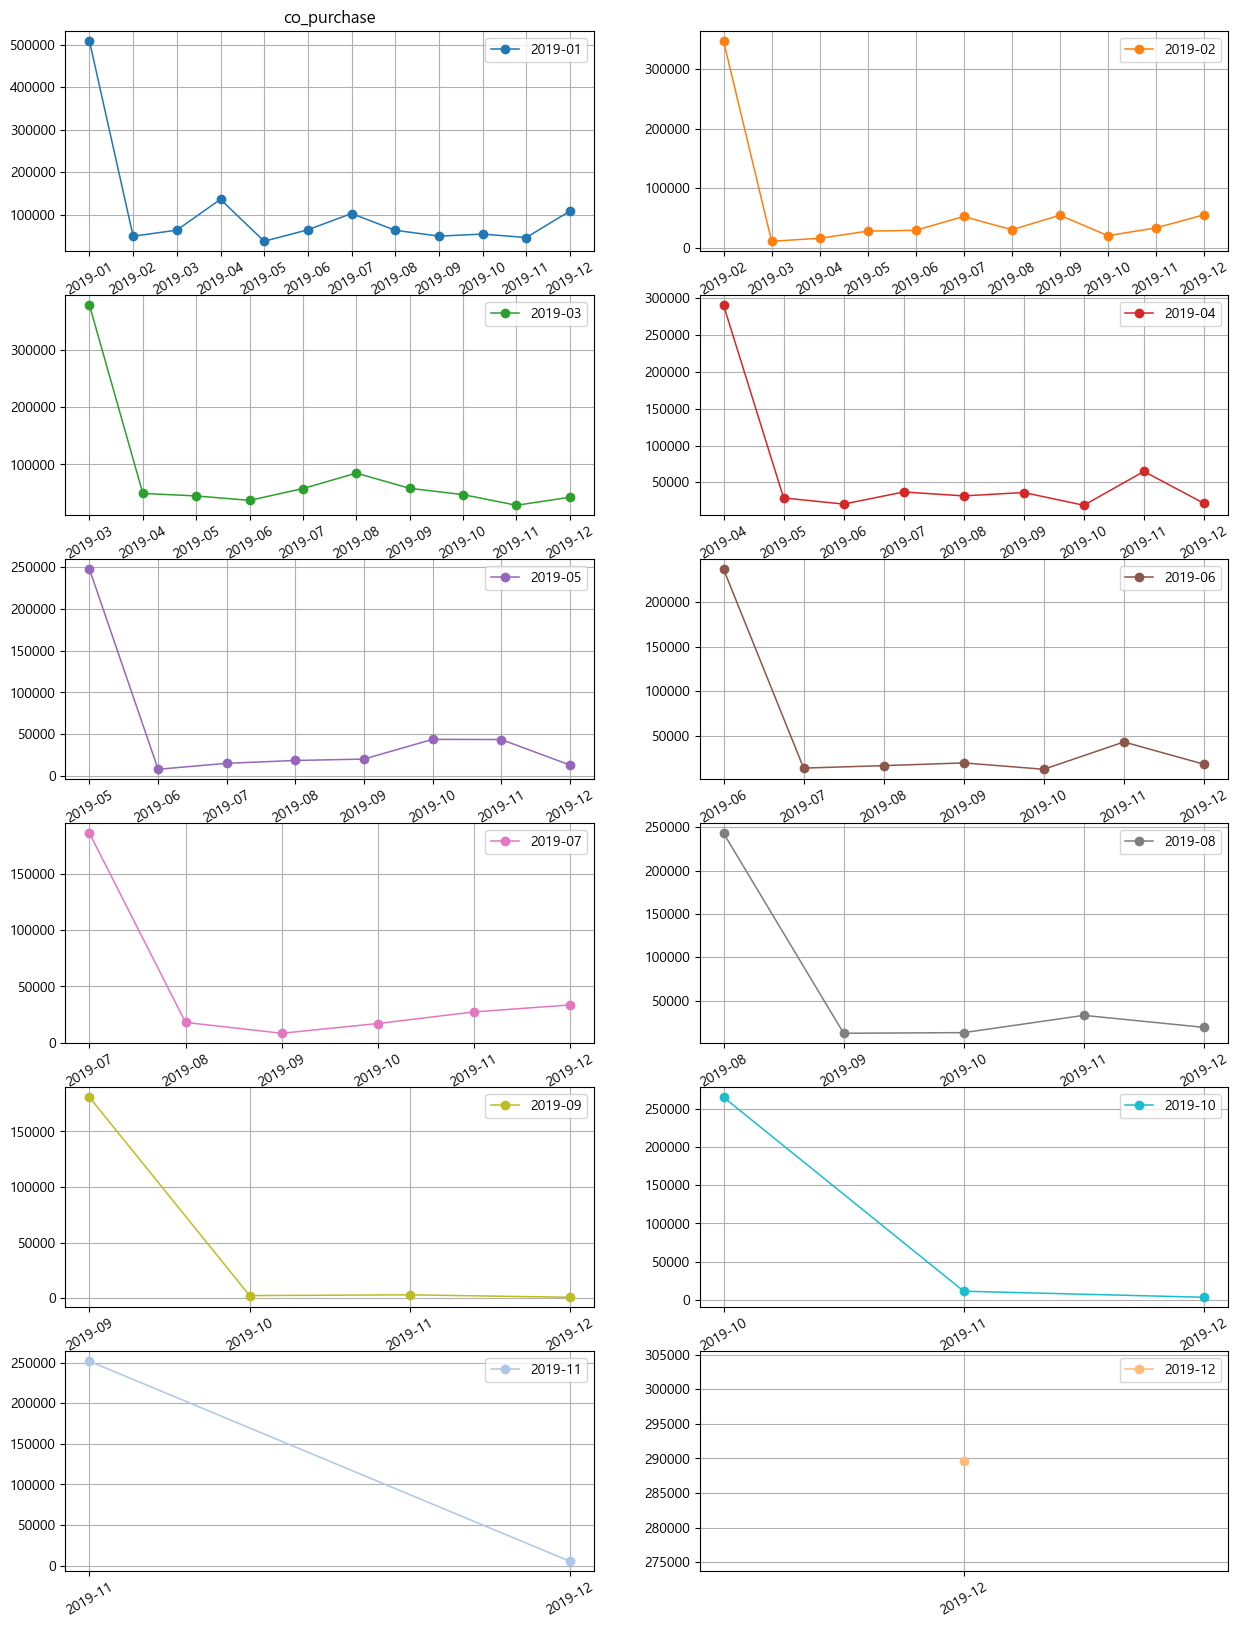

In [30]:
co_purchase = cohort_analysis(pd.read_csv('./preprocessing/co_purchase.csv'))
co_purchase.change_index_col_number(feature = cal_df, month_colname = 'month')

co_purchase.change_for_cohort_graph()

co_purchase.cohort_graph(title = 'co_purchase')
co_purchase.cohort_graph_subplot(title = 'co_purchase')

### (4) 코호트 군집 분석, Feature Engineering

In [31]:
def up_down_check(df): # 전월 대비 증감이 얼마나 있었는지 확인
    dict_df = {}
    for i in df.columns:
        count=0
        for j in range(1, len(df.columns)):
            if df.loc[j,i] < df.loc[j+1,i]: # 뒤에 오는 숫자가 더 크다.
                # print( 'up', df.loc[j,i], df.loc[j+1,i])
                count+=1
            elif df.loc[j,i] > df.loc[j+1,i]: # 뒤에 오는 숫자가 더 작다.
                # print( 'down', df.loc[j,i], df.loc[j+1,i])
                count-=1
        dict_df[str(i)] = count
        
    return dict_df

def up_down_merge(df, up_down_dict, new_col_name, period_col): # updown 정보를 결합
    for i in up_down_dict.keys():
        # print(i, up_down_dict[i])
        df.loc[df[period_col]==i, new_col_name] = up_down_dict[i]
    return df

is_back_temp = is_back.df.T
is_back_temp = is_back_temp.fillna(0)
is_back_up_down = up_down_check(is_back_temp)

total_information_first_ord = total_information.groupby('고객ID', as_index=False)['거래날짜'].min()
total_information_first_ord = to_month(total_information_first_ord,'거래날짜')

up_down_df = up_down_merge(df=total_information_first_ord, up_down_dict=is_back_up_down,new_col_name ='is_back_up_down', period_col = '거래날짜')

### (5) 분석 - 마케팅 비용과 코호트 군집 간의 상관관계 분석

In [32]:
up_down_df_cohort = up_down_df.copy() 
up_down_df_cohort.drop_duplicates(subset=['거래날짜', 'is_back_up_down'], keep='first', inplace=True, ignore_index=True)
up_down_df_cohort.drop('고객ID', axis=1, inplace=True)
up_down_df_cohort.sort_values(by='거래날짜', inplace=True)
up_down_df_cohort.reset_index(drop=True, inplace=True)

up_down_df_cohort.rename(columns = {'거래날짜':'날짜'}, inplace=True)

Marketing_info_cohort = Marketing_info.copy()
Marketing_info_cohort = to_month(Marketing_info_cohort,'날짜')
Marketing_info_cohort = Marketing_info_cohort.groupby(by='날짜', as_index=False)[['오프라인비용','온라인비용']].sum() # 월별로 평균적으로 쓴 마케팅 금액이 얼마인지 확인

cohort_relation = pd.merge(up_down_df_cohort, Marketing_info_cohort, on='날짜', how='inner')
cohort_relation

,날짜,is_back_up_down,오프라인비용,온라인비용
0,2019-01,1.0,96600,58328.95
1,2019-02,-1.0,81300,55807.92
2,2019-03,-1.0,73500,48750.09
3,2019-04,-4.0,96000,61026.83
4,2019-05,-2.0,65500,52759.64
5,2019-06,-3.0,80500,53818.14
6,2019-07,-2.0,67500,52717.85
7,2019-08,-3.0,85500,57404.15
8,2019-09,-4.0,83000,52514.54
9,2019-10,-3.0,93500,57724.65


<Axes: xlabel='온라인비용', ylabel='Count'>

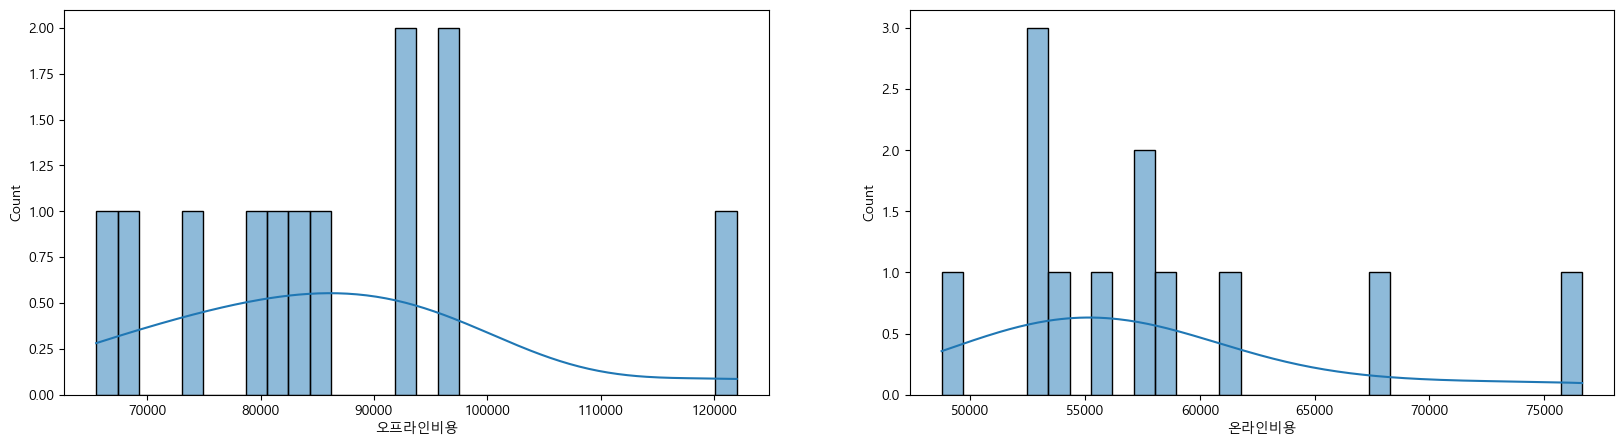

In [33]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.histplot(cohort_relation['오프라인비용'], bins=30, kde=True)

plt.subplot(1,2,2)
sns.histplot(cohort_relation['온라인비용'],  bins=30, kde=True)

---------------------------------------------------------------------------------------------------- 
pearson 상관계수 분석
----------------------------------------------------------------------------------------------------
오프라인비용


PearsonRResult(statistic=0.1460611697624304, pvalue=0.6505827969743276)

오프라인비용는 타겟에 주는 영향이 미미하다.
온라인비용


PearsonRResult(statistic=0.1481638116581448, pvalue=0.6458419451472261)

온라인비용는 타겟에 주는 영향이 미미하다.


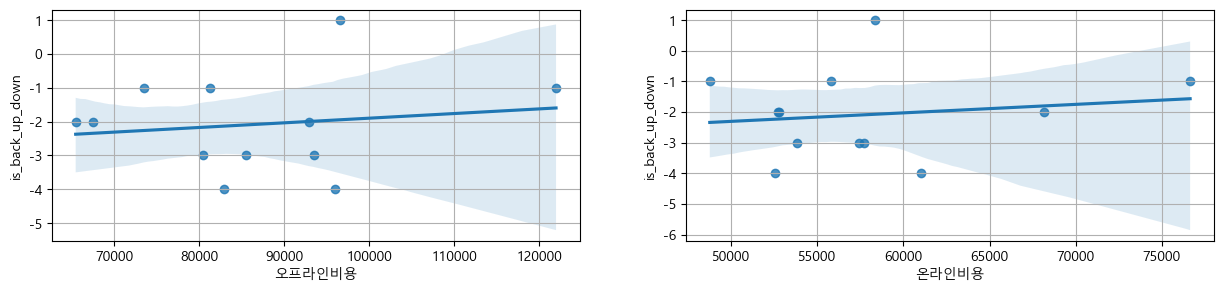

In [34]:
def pearson_analyze(df, target, feature_list):
    print('-'*100, '\npearson 상관계수 분석')
    print('-'*100)
    for feature in feature_list:
        print(f'{feature}')
        result = sp.pearsonr(df[feature], df[target])
        display(result)
        if result[1]>0.05:
            print(f'{feature}는 타겟에 주는 영향이 미미하다.')
        else:
            print(f'{feature}는 타겟과 상관관계를 갖는다.')
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    sns.regplot(x=feature_list[0], y=target, data=df)
    plt.grid()

    plt.subplot(1,2,2)
    sns.regplot(x=feature_list[1], y=target, data=df)
    plt.grid()
    plt.show()
pearson_analyze(cohort_relation, 'is_back_up_down', ['오프라인비용','온라인비용'])

#### 다른 차트와 함께 비교

In [ ]:
graph_information = pd.read_csv('./preprocessing/total_information.csv')
graph_information['거래날짜'] = pd.to_datetime(graph_information['거래날짜']).dt.to_period('M').astype(str)

graph_customer = graph_information.groupby(by='거래날짜', as_index=False)[['고객ID']].nunique()
graph_transaction = graph_information.groupby(by='거래날짜', as_index=False)[['거래ID']].count()
graph_money = graph_information.groupby(by='거래날짜', as_index = False)['Total_Purchase_Amount'].sum()

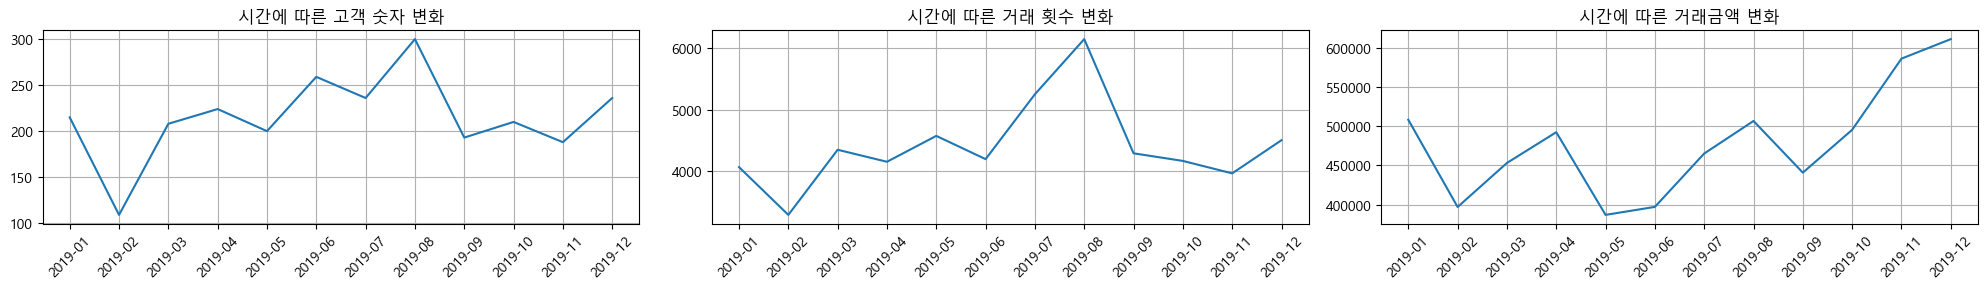

In [ ]:
plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.title('시간에 따른 고객 숫자 변화')
plt.plot('거래날짜', '고객ID', data = graph_customer)
plt.xticks(rotation=45)
plt.grid()

plt.subplot(1,3,2)
plt.title('시간에 따른 거래 횟수 변화')
plt.plot('거래날짜', '거래ID', data = graph_transaction)
plt.xticks(rotation=45)
plt.grid()

plt.subplot(1,3,3)
plt.title('시간에 따른 거래금액 변화')
plt.plot('거래날짜', 'Total_Purchase_Amount', data = graph_money)
plt.xticks(rotation=45)
plt.grid()

plt.tight_layout()

## 6. 지역별 차트 작성, 어디가 주목할 지역인가?

In [ ]:
class global_analysis_class:
    def __init__(self, df, city_col, customer_ID_col, transaction_ID_col, purchase_col):
        self.df = df
        self.city_col = city_col
        self.customer_info = customer_ID_col
        self.transaction_info = transaction_ID_col
        self.purchase_info = purchase_col
    def group_datasetting(self):
        self.global_customer = self.df.groupby(by = self.city_col, as_index=False)[[self.customer_info]].nunique()
        self.global_transaction = self.df.groupby(by = self.city_col, as_index=False)[[self.transaction_info]].count()
        self.global_money = self.df.groupby(by = self.city_col, as_index=False)[[self.purchase_info]].sum()

        self.global_money_per_customer = self.global_money.copy() # 고객당  평균 거래금액
        self.global_money_per_customer[self.customer_info] = self.global_customer[self.customer_info]
        self.global_money_per_customer['money_per_customer'] = self.global_money[self.purchase_info] / self.global_customer[self.customer_info]
        self.global_money_per_transaction = self.global_money.copy() # 거래당 평균 거래금액
        self.global_money_per_transaction[self.transaction_info] = self.global_transaction[self.transaction_info]
        self.global_money_per_transaction['money_per_transaction'] = self.global_money[self.purchase_info] / self.global_transaction[self.transaction_info]
        self.global_transaction_per_customer = self.global_transaction.copy()# 고객당 평균 거래횟수
        self.global_transaction_per_customer[self.customer_info] = self.global_customer[self.customer_info]# 고객당 평균 거래횟수
        self.global_transaction_per_customer['transaction per customer'] = self.global_transaction[self.transaction_info] / self.global_customer[self.customer_info]
        
    
    def basic_graph(self):
        plt.figure(figsize=(20,5))
        plt.subplot(1,3,1)
        plt.bar(self.global_customer[self.city_col], self.global_customer[self.customer_info].values, label = self.global_customer['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'])
        plt.title('지역별, 고객 숫자')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        
        plt.subplot(1,3,2)
        plt.bar(self.global_transaction[self.city_col], self.global_transaction[self.transaction_info].values, label = self.global_transaction['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'])
        plt.title('지역별, 거래 횟수')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        
        plt.subplot(1,3,3)
        plt.bar(self.global_money[self.city_col], self.global_money[self.purchase_info].values, label = self.global_money['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'])
        plt.title('지역별, 거래금액')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()

    def detail_graph(self):
        plt.figure(figsize=(20,5))
        plt.subplot(1,2,1)
        plt.bar(self.global_money_per_customer[self.city_col], self.global_money_per_customer['money_per_customer'].values, label = self.global_money_per_customer['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'] )
        plt.title('지역별, 고객당 거래금액 평균')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        

        plt.subplot(1,2,2)
        plt.bar(self.global_transaction_per_customer[self.city_col], self.global_transaction_per_customer['transaction per customer'].values, label = self.global_transaction_per_customer['고객지역'], color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque'])
        plt.title('지역별, 고객당 거래 횟수 평균')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()

    def gender(self, gender_col, male, female):
        self.gender_col = gender_col
        self.gender_pivot = pd.pivot_table(self.df, index=self.city_col, columns = self.gender_col, values=self.customer_info, aggfunc='nunique')
        self.gender_pivot.plot(kind='bar', color = ['plum', 'bisque'], figsize=(5,3))


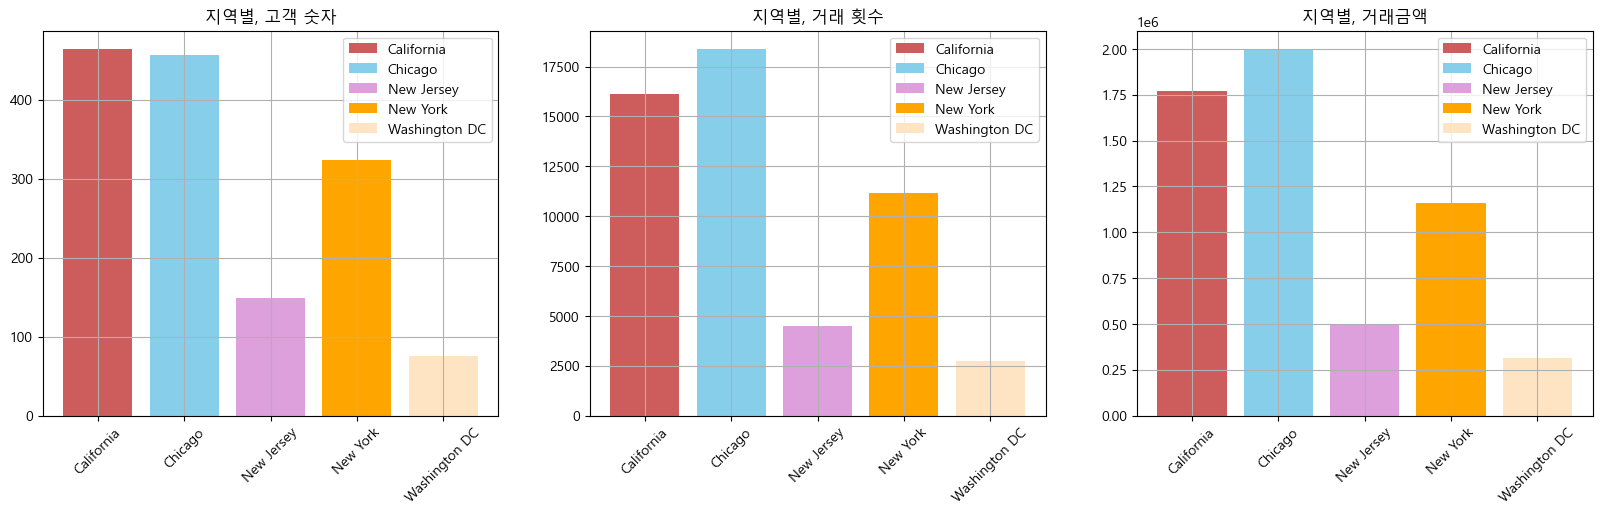

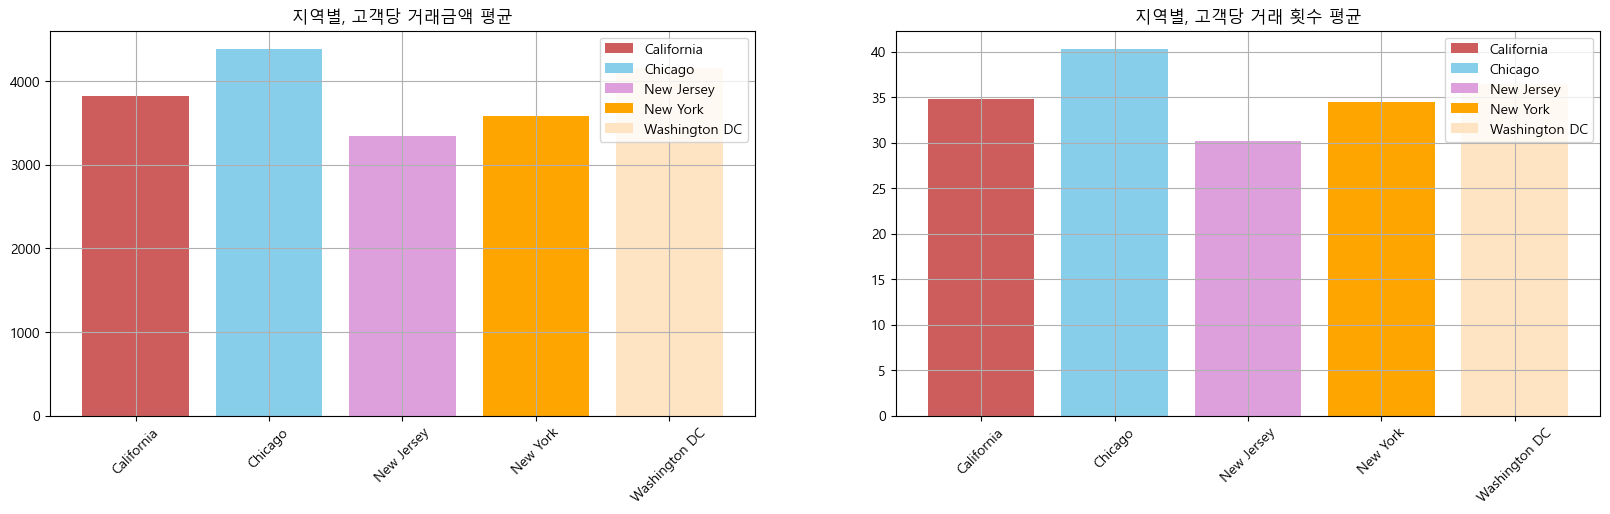

In [ ]:
global_analysis_byclass = global_analysis_class(pd.read_csv('./preprocessing/total_information.csv'), '고객지역', '고객ID', '거래ID', 'Total_Purchase_Amount')
global_analysis_byclass.group_datasetting()
global_analysis_byclass.basic_graph()
global_analysis_byclass.detail_graph()

In [ ]:
graph_product = pd.read_csv('./preprocessing/total_information.csv') 
graph_product = to_month(graph_product, '거래날짜')
graph_product = pd.merge(rfm_kmean_merge, graph_product, on='고객ID').drop(['Recency_Grade', 'Frequency_Grade','Monetary_Grade'], axis=1)
# graph_product_count = pd.pivot_table(graph_product, index='고객지역', columns = '제품카테고리', values='수량', aggfunc='count', margins=True).fillna(0)
graph_product_money = pd.pivot_table(graph_product, index='고객지역', columns='제품카테고리', values='Total_Purchase_Amount', aggfunc='mean', margins=True).fillna(0)
# display(graph_product_count)
# display(graph_product_money)

In [ ]:
def ratio(df, all_col): # 비율을 구해보자
    df_new = df.copy()
    for i in list(df_new.columns):
        df_new[i] = df_new[i]/df_new['All']
    df_new.drop('All', inplace=True)
    df_new.drop('All', axis=1,inplace=True)
    return df_new
pd.set_option('display.max_columns', None)
# graph_product_count = ratio(graph_product_count, 'All')
graph_product_money = ratio(graph_product_money, 'All')
# display(graph_product_count)
# display(graph_product_money)

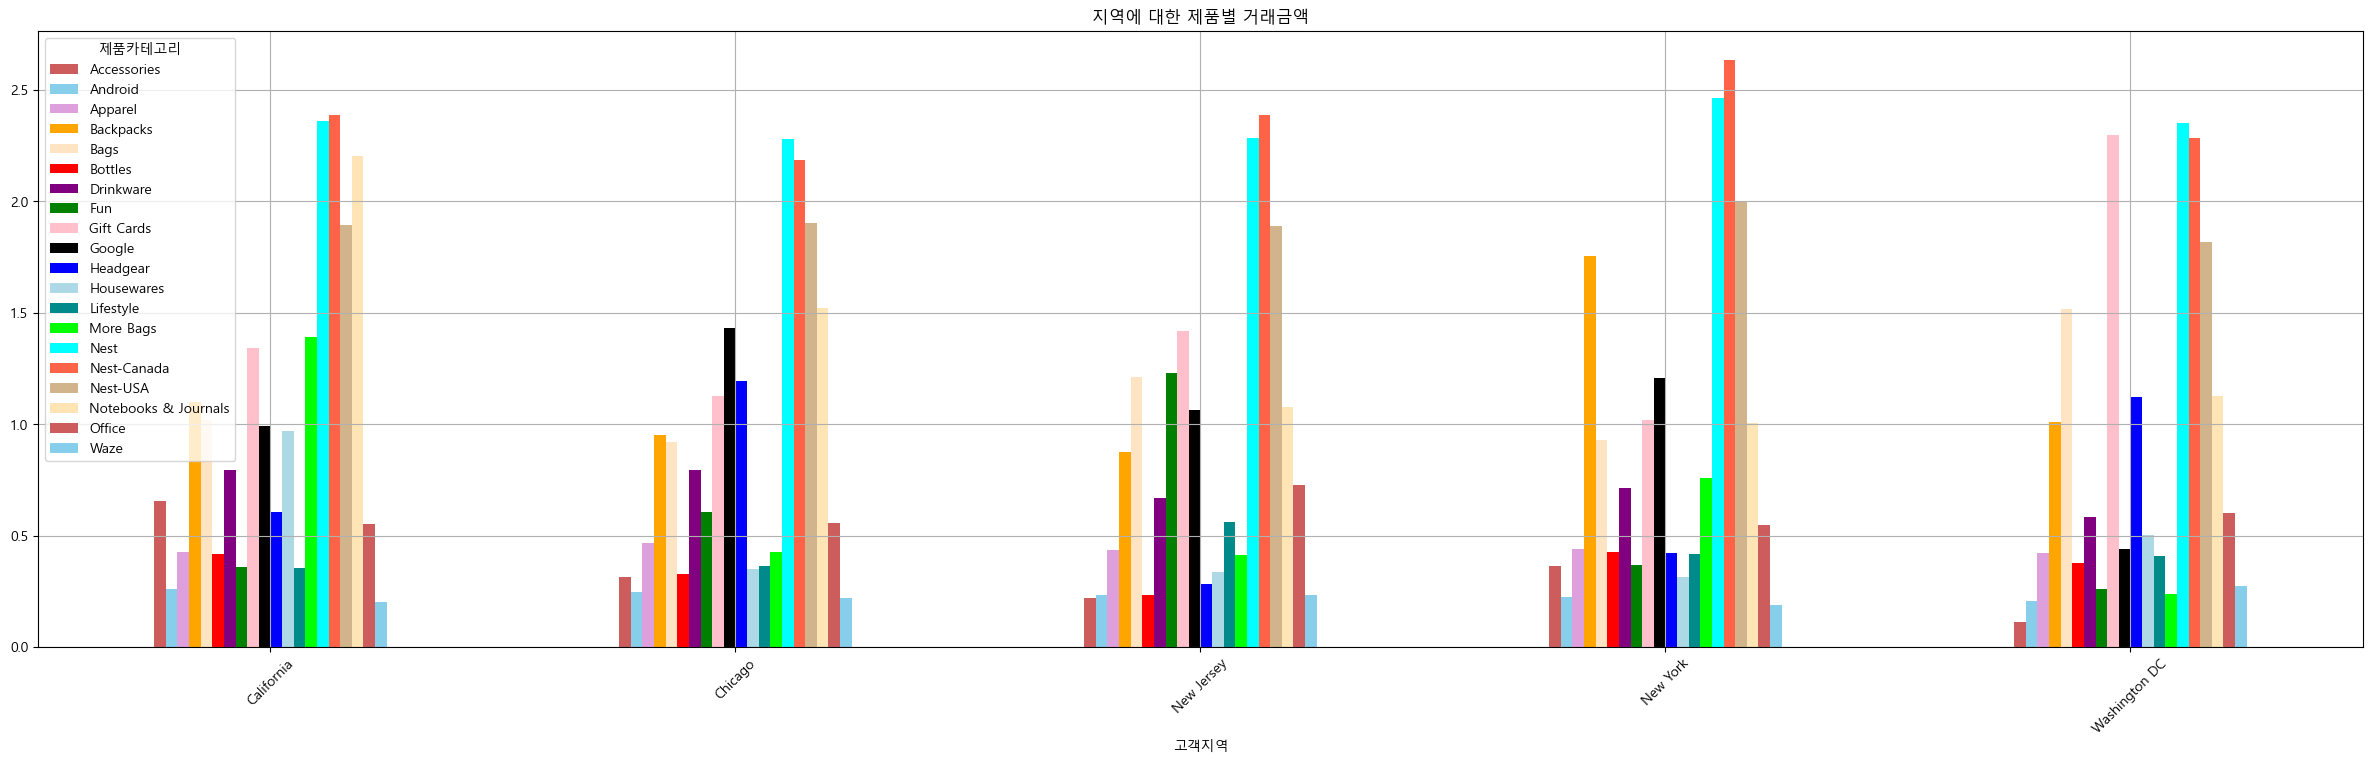

In [ ]:
graph_product_money.plot(kind='bar', figsize=(30,8),color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque', 'red', 'purple', 'Green', 'Pink', 'black',
                                                              'blue', 'lightblue', 'darkcyan', 'lime','aqua','tomato', 'tan', 'moccasin'])
plt.title('지역에 대한 제품별 거래금액')
plt.xticks(rotation=45)
plt.grid()

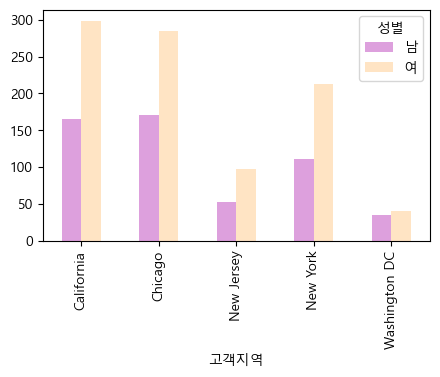

In [ ]:
global_analysis_byclass.gender('성별','남', '여')

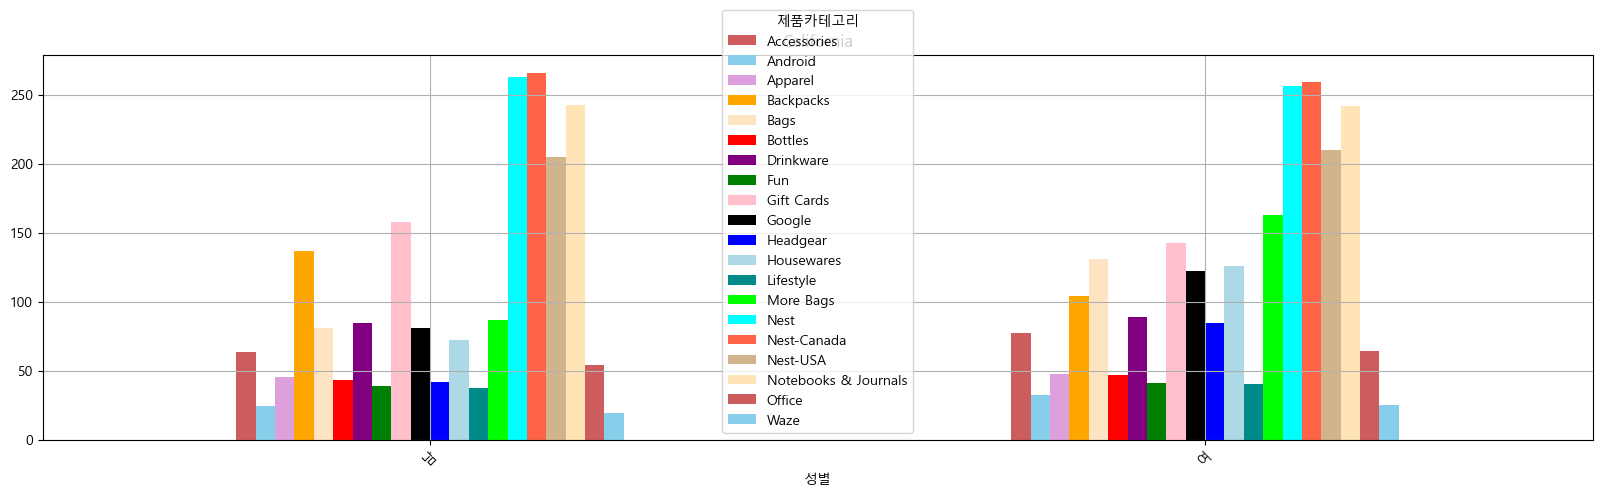

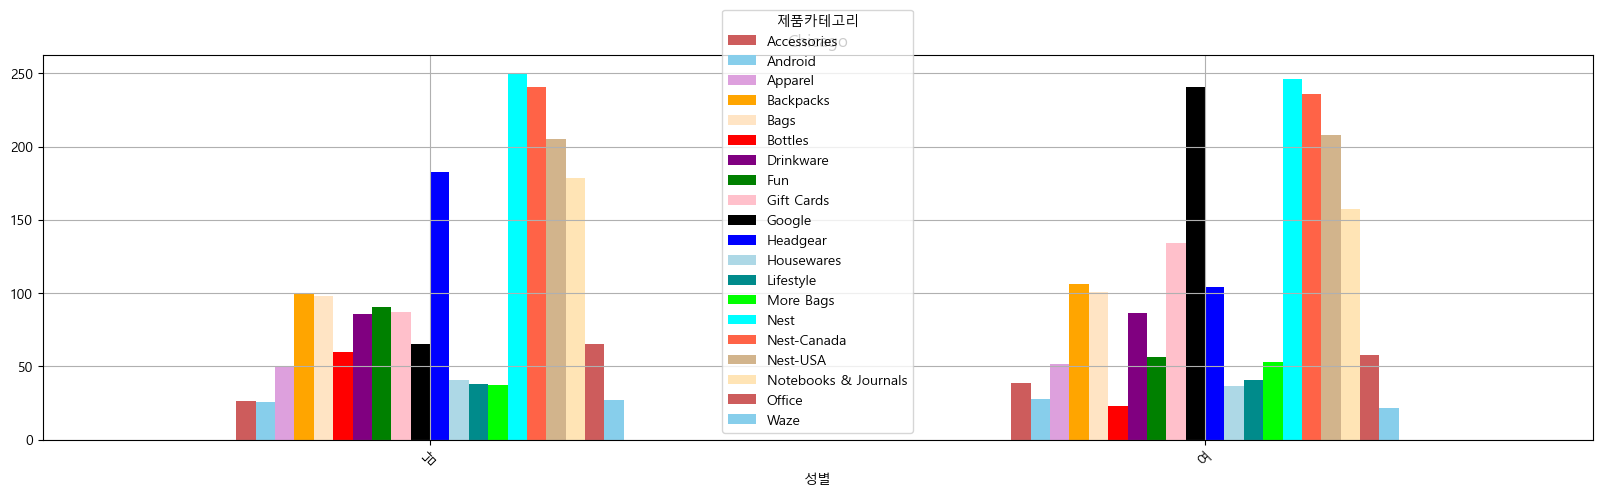

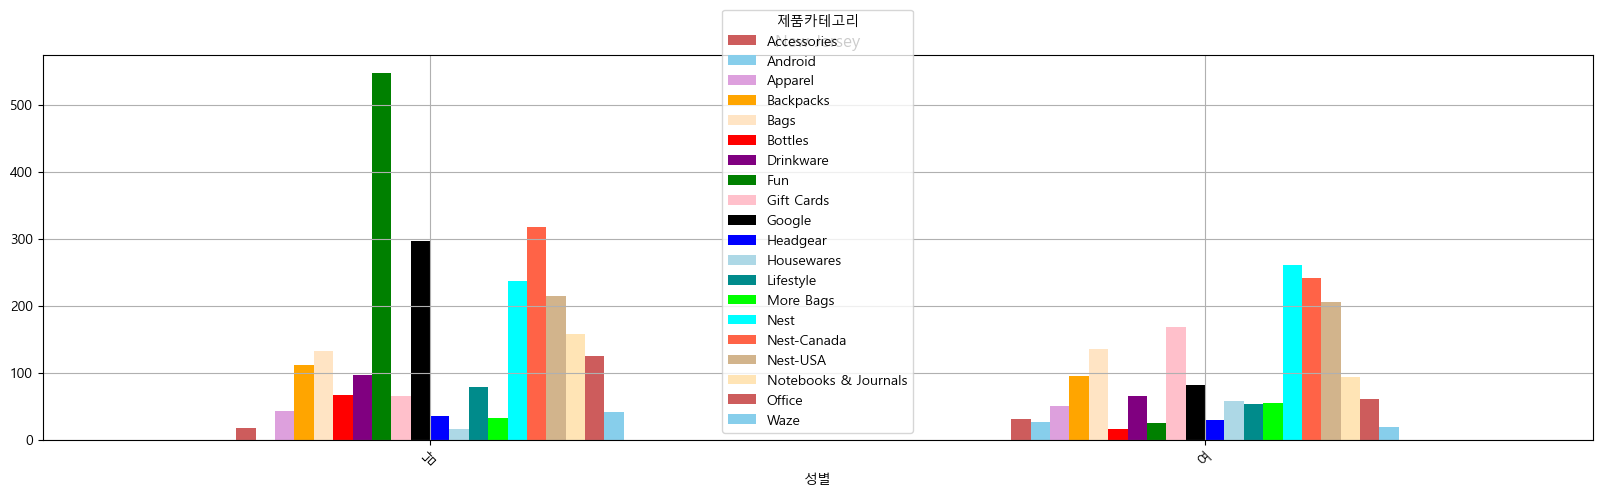

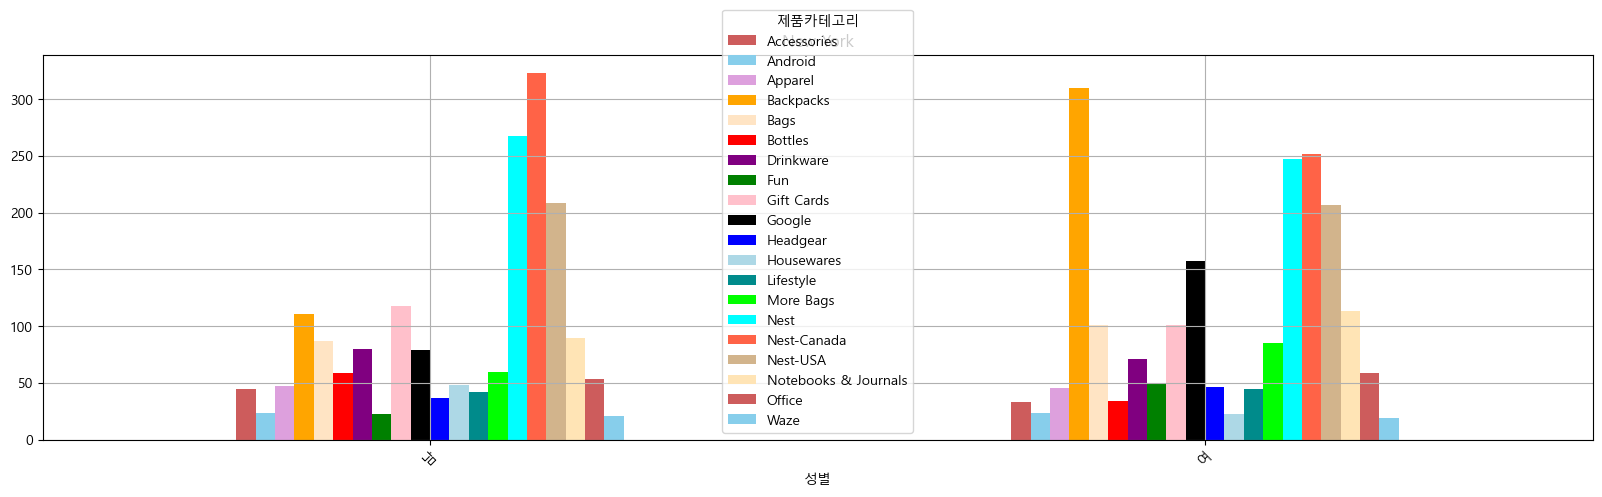

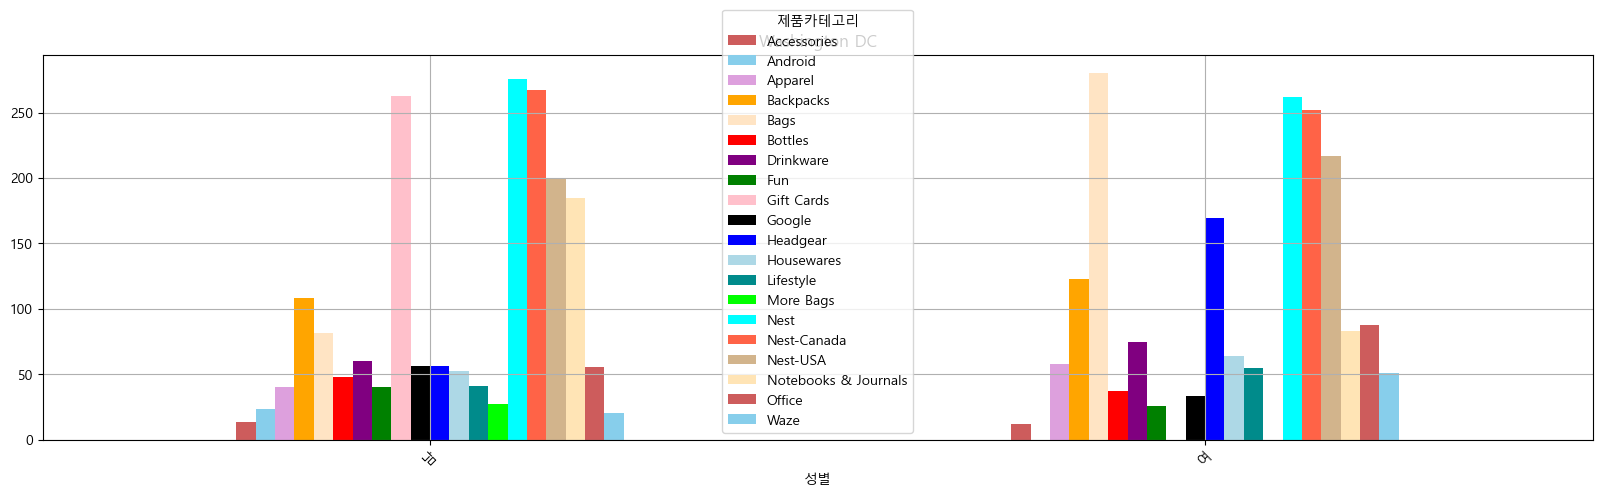

In [ ]:
def city_gender_product(df, city_col, city, gender_col, male, female, product_col, money_col): # 성별로 어디에 돈을 많이 소비하는지 확인하자
    df_new = df.loc[df[city_col]==city]
    df_new = pd.pivot_table(df_new,index = gender_col, columns = product_col, values=money_col, aggfunc='mean')
    df_new.plot(kind='bar', figsize=(20,5), color = ['indianred', 'skyblue', 'plum', 'orange', 'bisque', 'red', 'purple', 'Green', 'Pink', 'black',
                                                         'blue', 'lightblue', 'darkcyan', 'lime','aqua','tomato', 'tan', 'moccasin'])
    plt.title(city)
    plt.grid()
    plt.xticks(rotation=45)
    return df_new

California_gender = city_gender_product(global_analysis_byclass.df, '고객지역', 'California', '성별', '남', '여', '제품카테고리','Total_Purchase_Amount')
Chicago_gender = city_gender_product(global_analysis_byclass.df, '고객지역', 'Chicago', '성별', '남', '여', '제품카테고리', 'Total_Purchase_Amount')
New_Jersey_gender = city_gender_product(global_analysis_byclass.df, '고객지역', 'New Jersey', '성별', '남', '여', '제품카테고리', 'Total_Purchase_Amount')
New_York = city_gender_product(global_analysis_byclass.df, '고객지역', 'New York', '성별', '남', '여', '제품카테고리', 'Total_Purchase_Amount')
Washington_gender = city_gender_product(global_analysis_byclass.df, '고객지역', 'Washington DC', '성별', '남', '여', '제품카테고리', 'Total_Purchase_Amount')

> California
>- 고객 숫자 많다(1등)
>- 거래 횟수 많다(2등)
>- 소비 금액 많다.(2등)
>- 고객당 평균 거래금액(3등)
>- 1건당 평균 거래금액(3등)
>- 고객당 평균 거래 횟수(3등)

> Chicago
>- 고객 숫자 많다(2등)
>- 거래 횟수 많다(1등)
>- 소비 금액 많다.(1등)
>- 고객당 평균 거래금액(1등) 
>- 1건당 평균 거래금액(4등)
>- 고객당 평균 거래 횟수(1등)

>New Jersey
>- 고객 숫자 적다(4등)
>- 거래 횟수 적다(4등)
>- 소비 금액 적다(4등)
>- 고객당 평균 거래금액(5등)
>- 1건당 평균 거래금액(2등)
>- 고객당 평균 거래 횟수(5등)

>New York
>- 고객 숫자 보통(3등)
>- 거래 횟수 보통(3등)
>- 소비 금액 보통(3등)
>- 고객당 평균 거래금액(4등)
>- 1건당 평균 거래금액(5등)
>- 고객당 평균 거래 횟수(4등)

>Washington DC
>- 고객 숫자 적다(5등)
>- 거래 횟수 적다(5등)
>- 소비 금액 적다(5등)
>- 고객당 평균 거래금액(2등) 
>- 1건당 평균 거래금액(1등)
>- 고객당 평균 거래 횟수(2등)

## 7. 장바구니 분석

In [ ]:
# 거래ID별로 제품ID를 리스트로 그룹화
transactions = Onlinesales_info.groupby('거래ID')['제품ID'].apply(list).values.tolist()

# TransactionEncoder를 사용하여 데이터 변환
encoder = TransactionEncoder()
encoded_array = encoder.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(encoded_array, columns=encoder.columns_)

# apriori 알고리즘을 사용하여 빈번한 아이템 세트 찾기
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

# 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# 연관 규칙 출력
print(rules.sort_values(by='confidence', ascending=False).head(10))

      antecedents     consequents  antecedent support  consequent support  \
0  (Product_0917)  (Product_0915)            0.014644            0.017677   
1  (Product_0915)  (Product_0917)            0.017677            0.014644   
2  (Product_0976)  (Product_0983)            0.128886            0.132796   
3  (Product_0983)  (Product_0976)            0.132796            0.128886   

    support  confidence       lift  leverage  conviction  zhangs_metric  
0  0.010654    0.727520  41.156636  0.010395    3.605126       0.990203  
1  0.010654    0.602709  41.156636  0.010395    2.480185       0.993260  
2  0.027653    0.214551   1.615644  0.010537    1.104087       0.437430  
3  0.027653    0.208233   1.615644  0.010537    1.100216       0.439403  


- 규칙 0: 제품 0917을 구매했을 때, 제품 0915를 함께 구매할 확률이 약 72.75% 이 규칙의 lift 값이 41.15로 매우 높으므로, 두 제품 간의 매우 강한 양의 연관성이 있음
- 규칙 1: 제품 0915를 구매했을 때, 제품 0917을 함께 구매할 확률이 약 60.27% lift 값이 규칙 0과 동일하게 높으므로, 이 두 제품은 서로 매우 강한 양의 연관성
- 규칙 3과 2: 제품 0976을 구매했을 때, 제품 0983을 함께 구매할 확률은 약 21.45%, 그리고 그 반대의 경우도 비슷한 확률. 이 규칙들의 lift 값은 1.61로, 두 제품이 서로 구매될 확률이 독립적인 경우보다 약간 더 높음

In [ ]:
filtered_data = Onlinesales_info[Onlinesales_info['제품ID'].isin(['Product_0915', 'Product_0917'])]
display(filtered_data)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
232,USER_1267,Transaction_0129,2019-01-03,Product_0915,Lifestyle,1,3.61,6.50,Clicked
300,USER_0284,Transaction_0168,2019-01-03,Product_0915,Lifestyle,1,3.61,6.50,Clicked
302,USER_0284,Transaction_0168,2019-01-03,Product_0917,Lifestyle,1,3.61,6.50,Clicked
422,USER_1358,Transaction_0242,2019-01-04,Product_0915,Lifestyle,26,3.47,6.50,Clicked
424,USER_1358,Transaction_0242,2019-01-04,Product_0917,Lifestyle,26,3.47,6.50,Not Used
...,...,...,...,...,...,...,...,...,...
45908,USER_0234,Transaction_20898,2019-11-13,Product_0917,Lifestyle,3,3.50,6.00,Clicked
45997,USER_0794,Transaction_20945,2019-11-14,Product_0917,Lifestyle,2,2.80,6.00,Not Used
46084,USER_1336,Transaction_20982,2019-11-14,Product_0915,Lifestyle,1,2.80,12.99,Used
46105,USER_0257,Transaction_20996,2019-11-14,Product_0917,Lifestyle,1,2.80,6.00,Not Used


- 상품을 배치하거나 프로모션을 기획할 때 관련성 높게 나온 제품들을 함께 추천하거나 패키지로 묶어 판매하는 전략..
- 예를 들어, 제품 0917과 0915는 함께 묶어 할인을 제공하거나, 함께 구매를 유도하는 마케팅 캠페인을 진행

In [ ]:
rfm_kmean_merge = pd.read_csv('./preprocessing/rfm_kmean_merge_segmentation.csv')
total_information_z = pd.read_csv('./preprocessing/total_information_z.csv')

def perform_association_analysis(data, segment_col, transaction_col, product_col):
    # 결과를 저장할 딕셔너리
    association_results = {}

    # 세그먼트별로 분석
    for segment in data[segment_col].unique():
        # 세그먼트 데이터 필터링
        segment_data = data[data[segment_col] == segment]

        # 거래ID별로 제품ID를 리스트로 변환
        transactions = segment_data.groupby(transaction_col)[product_col].apply(list).tolist()

        # TransactionEncoder로 데이터 변환
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df = pd.DataFrame(te_ary, columns=te.columns_)

        # apriori 알고리즘으로 빈번한 아이템 세트를 찾기
        frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

        # 연관 규칙을 생성
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)

        # 세그먼트별 결과 저장
        association_results[segment] = rules

    return association_results

# 데이터프레임에 세그먼트 정보 결합
merged_data = pd.merge(total_information_z, rfm_kmean_merge, on='고객ID')

# 연관 분석 수행
results = perform_association_analysis(merged_data, 'Customer_Segment', '거래ID', '제품ID')

# 결과 확인
for segment, rules in results.items():
    print(f"Results for {segment}:")
    print(rules)  # 또는 print(rules.head())를 사용하여 상위 몇 개의 규칙만 출력할 수 있습니다.
    print("\n")  # 세그먼트 간에 구분을 위해 줄바꿈 추가

Results for 수면 고객:
      antecedents     consequents  antecedent support  consequent support  \
0  (Product_0917)  (Product_0915)            0.014947            0.019218   
1  (Product_0915)  (Product_0917)            0.019218            0.014947   
2  (Product_0915)  (Product_0918)            0.019218            0.013469   
3  (Product_0918)  (Product_0915)            0.013469            0.019218   
4  (Product_0976)  (Product_0983)            0.135512            0.138962   
5  (Product_0983)  (Product_0976)            0.138962            0.135512   
6  (Product_0981)  (Product_0983)            0.156866            0.138962   
7  (Product_0983)  (Product_0981)            0.138962            0.156866   

    support  confidence       lift  leverage  conviction  zhangs_metric  
0  0.010841    0.725275  37.739081  0.010554    3.570046       0.988274  
1  0.010841    0.564103  37.739081  0.010554    2.259826       0.992578  
2  0.010348    0.538462  39.977486  0.010089    2.137484       0.

- 세그먼트 별로 연관 분석해보니 VIP 고객은 해당이 안되는 것 같음
- 수면 고객을 활성화 시키기위해서 묶어서 추천하는 마케팅
- 또는 신규고객과 미관심 고객에게는 해당 마케팅을 하면 그나마 의미가 있을 듯 함. 

## 8. 마케팅 전략

### 성별 VIP 인기 카테고리

In [44]:
rfm_region_gender = pd.merge(rfm_kmean_merge, total_information, on='고객ID')

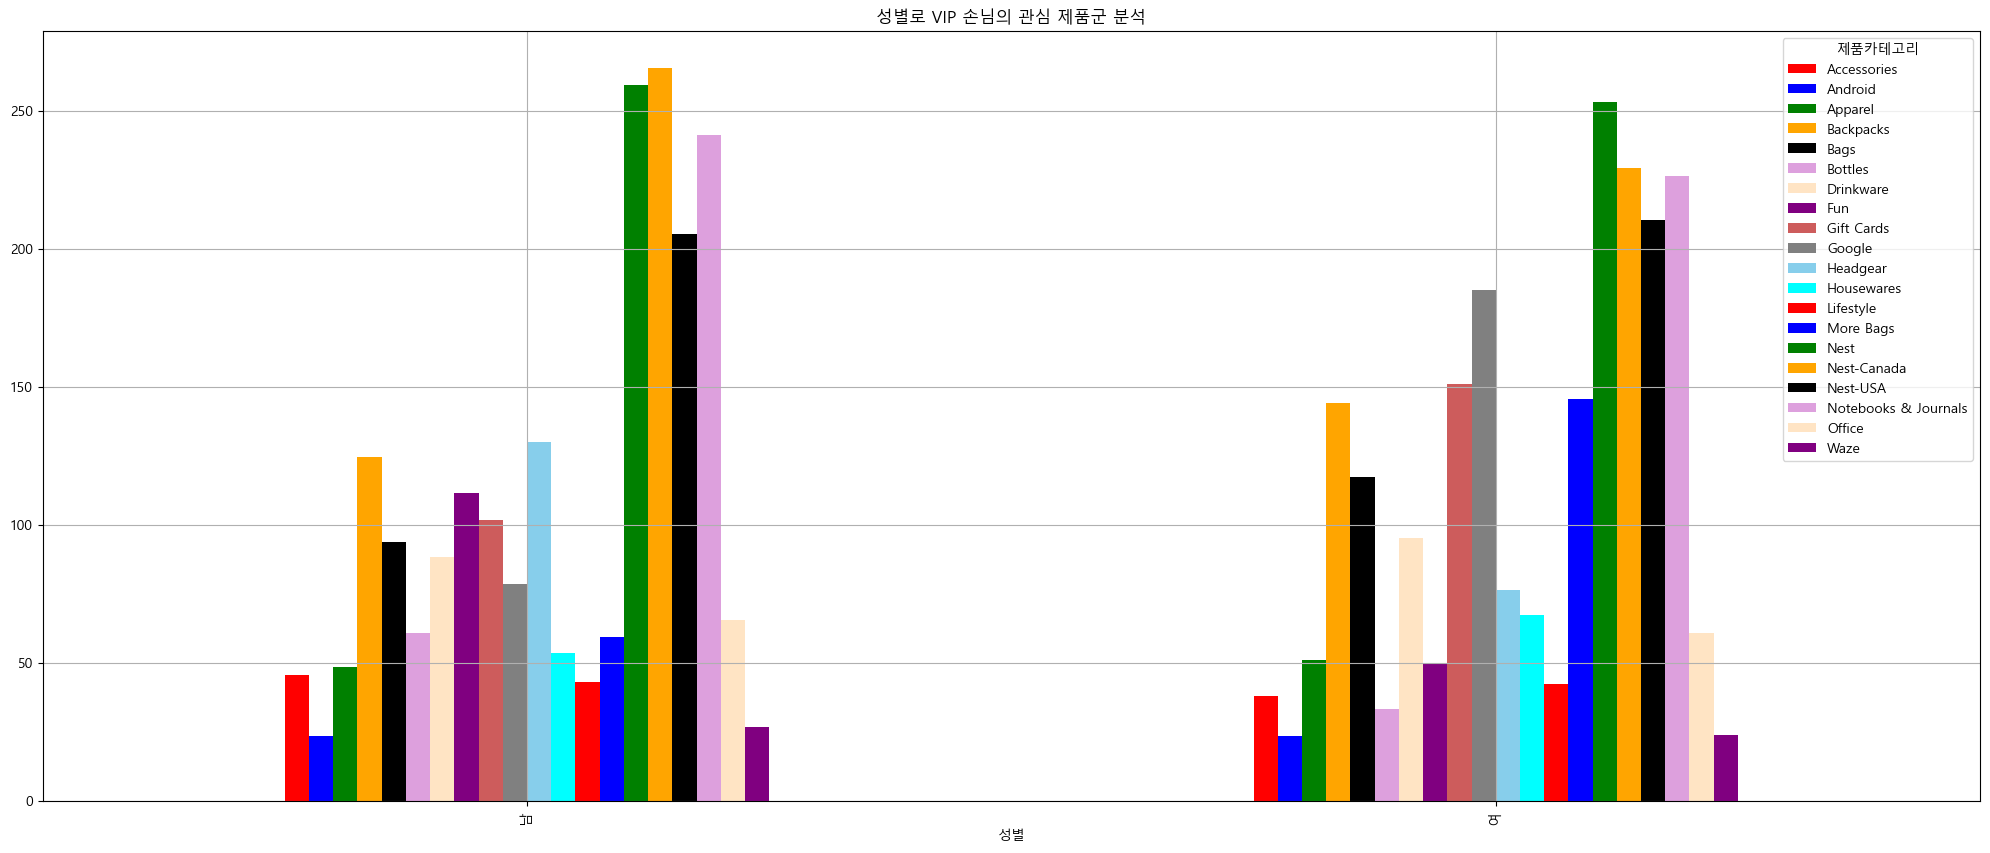

In [69]:
rfm_region_gender = rfm_region_gender.loc[rfm_region_gender['Customer_Segment']=='VIP 고객']
pd.pivot_table(rfm_region_gender, index = '성별', columns = '제품카테고리', values = 'Total_Purchase_Amount', aggfunc='mean').plot(kind='bar', color = ['Red','blue', 'Green', 'Orange', 'black', 
                                                                                                                                                'plum', 'bisque','purple', 'indianred', 'grey',
                                                                                                                                               'skyblue', 'cyan'])
plt.title('성별로 VIP 손님의 관심 제품군 분석')
plt.grid()

### 시간에 따른 제품카테고리별로 판매량 변화

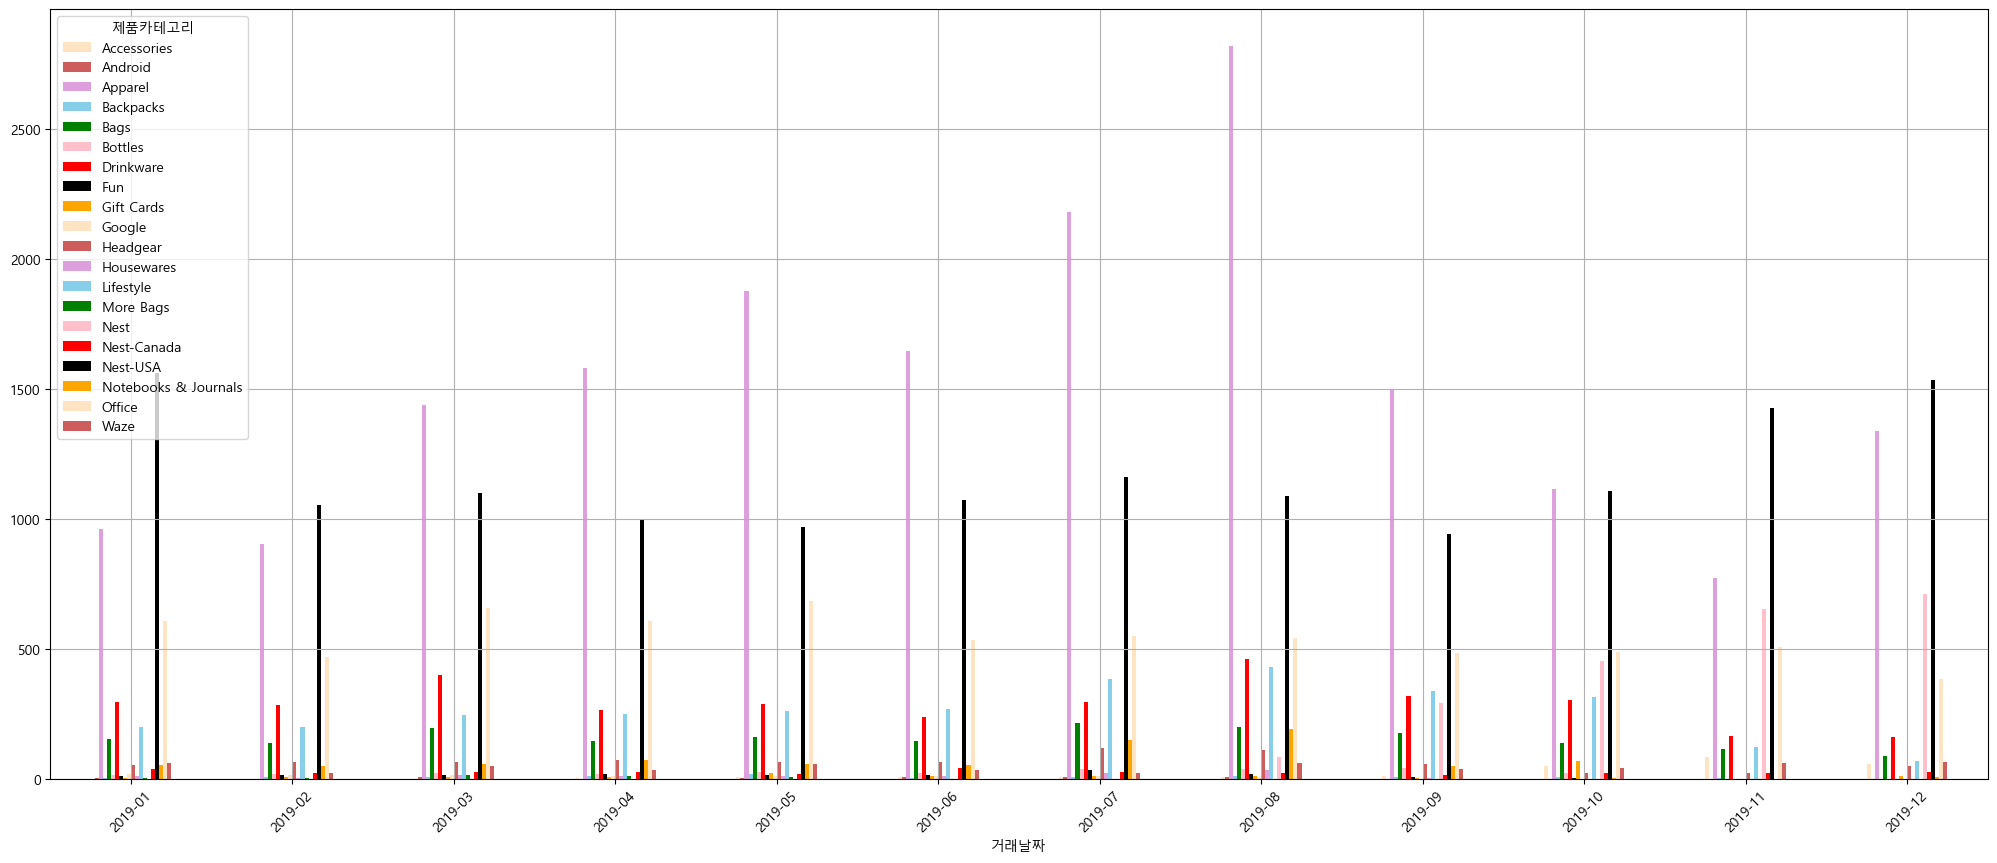

In [70]:
total_information_category = to_month(total_information, '거래날짜' )
total_information_category = pd.pivot_table(total_information_category, index = '거래날짜', columns = '제품카테고리', values = '수량', aggfunc='count')
total_information_category.fillna(0, inplace=True)
# total_information_category.drop('Apparel', axis=1, inplace=True)
total_information_category.plot(kind='bar', color = ['bisque', 'indianred', 'plum', 'skyblue', 'green', 'pink', 'red', 'black', 'orange'])
plt.grid()
plt.xticks(rotation=45)
plt.show()

### VIP 손님과 수면 고객이 관심이 있는 제품은 어떻게 다른가

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,Total_Purchase_Amount,Recency_Grade,Frequency_Grade,Monetary_Grade,Customer_Segment
0,USER_1358,Transaction_0000,2019-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,175.5810,1,4,4,수면 고객
1,USER_1358,Transaction_0001,2019-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,175.5810,1,4,4,수면 고객
2,USER_1358,Transaction_0013,2019-01,Product_0983,Nest-USA,2,122.77,6.5,Not Used,남,Chicago,12,0.10,276.5940,1,4,4,수면 고객
3,USER_1358,Transaction_0015,2019-01,Product_0984,Nest-USA,1,81.50,6.5,Clicked,남,Chicago,12,0.10,96.1500,1,4,4,수면 고객
4,USER_1358,Transaction_0016,2019-01,Product_0981,Nest-USA,1,153.71,6.5,Clicked,남,Chicago,12,0.10,175.5810,1,4,4,수면 고객
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0175,Transaction_23677,2019-12,Product_0992,Nest,1,100.91,6.5,Clicked,여,California,47,0.05,112.4555,4,1,1,신규 고객
52920,USER_0175,Transaction_23678,2019-12,Product_0994,Nest,1,355.74,6.5,Used,여,California,47,0.05,380.0270,4,1,1,신규 고객
52921,USER_0175,Transaction_23678,2019-12,Product_0996,Nest,2,49.95,6.5,Clicked,여,California,47,0.05,111.3950,4,1,1,신규 고객
52922,USER_0972,Transaction_23922,2019-12,Product_0994,Nest,1,355.74,6.5,Clicked,여,New York,41,0.05,380.0270,4,1,1,신규 고객


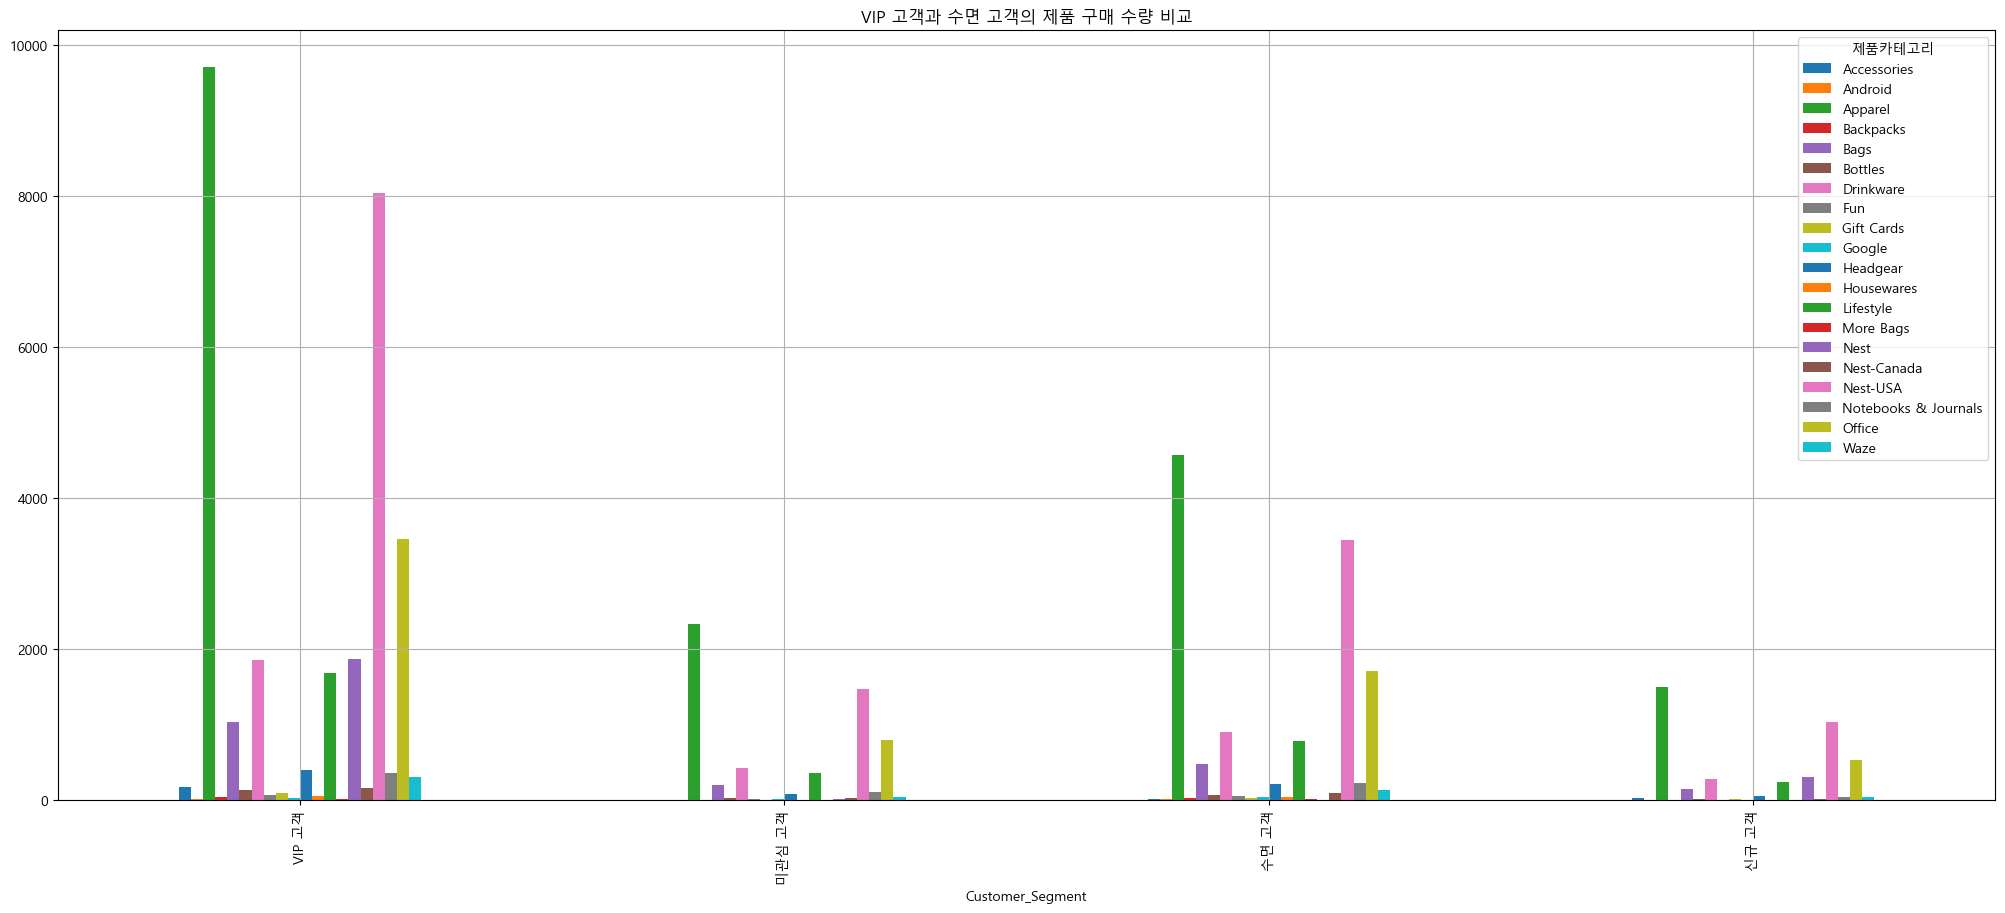

In [77]:
total_information_vip_plot = to_month(total_information, '거래날짜' )
total_information_vip_sleep_plot = pd.merge(total_information_vip_plot,rfm_kmean_merge, on = '고객ID' )
display(total_information_vip_sleep_plot)
total_information_vip_sleep_plot = pd.pivot_table(total_information_vip_sleep_plot,  index = 'Customer_Segment', columns = '제품카테고리', values = '수량', aggfunc='count')

total_information_vip_sleep_plot.plot(kind='bar')
plt.title('VIP 고객과 수면 고객의 제품 구매 수량 비교')
plt.grid()

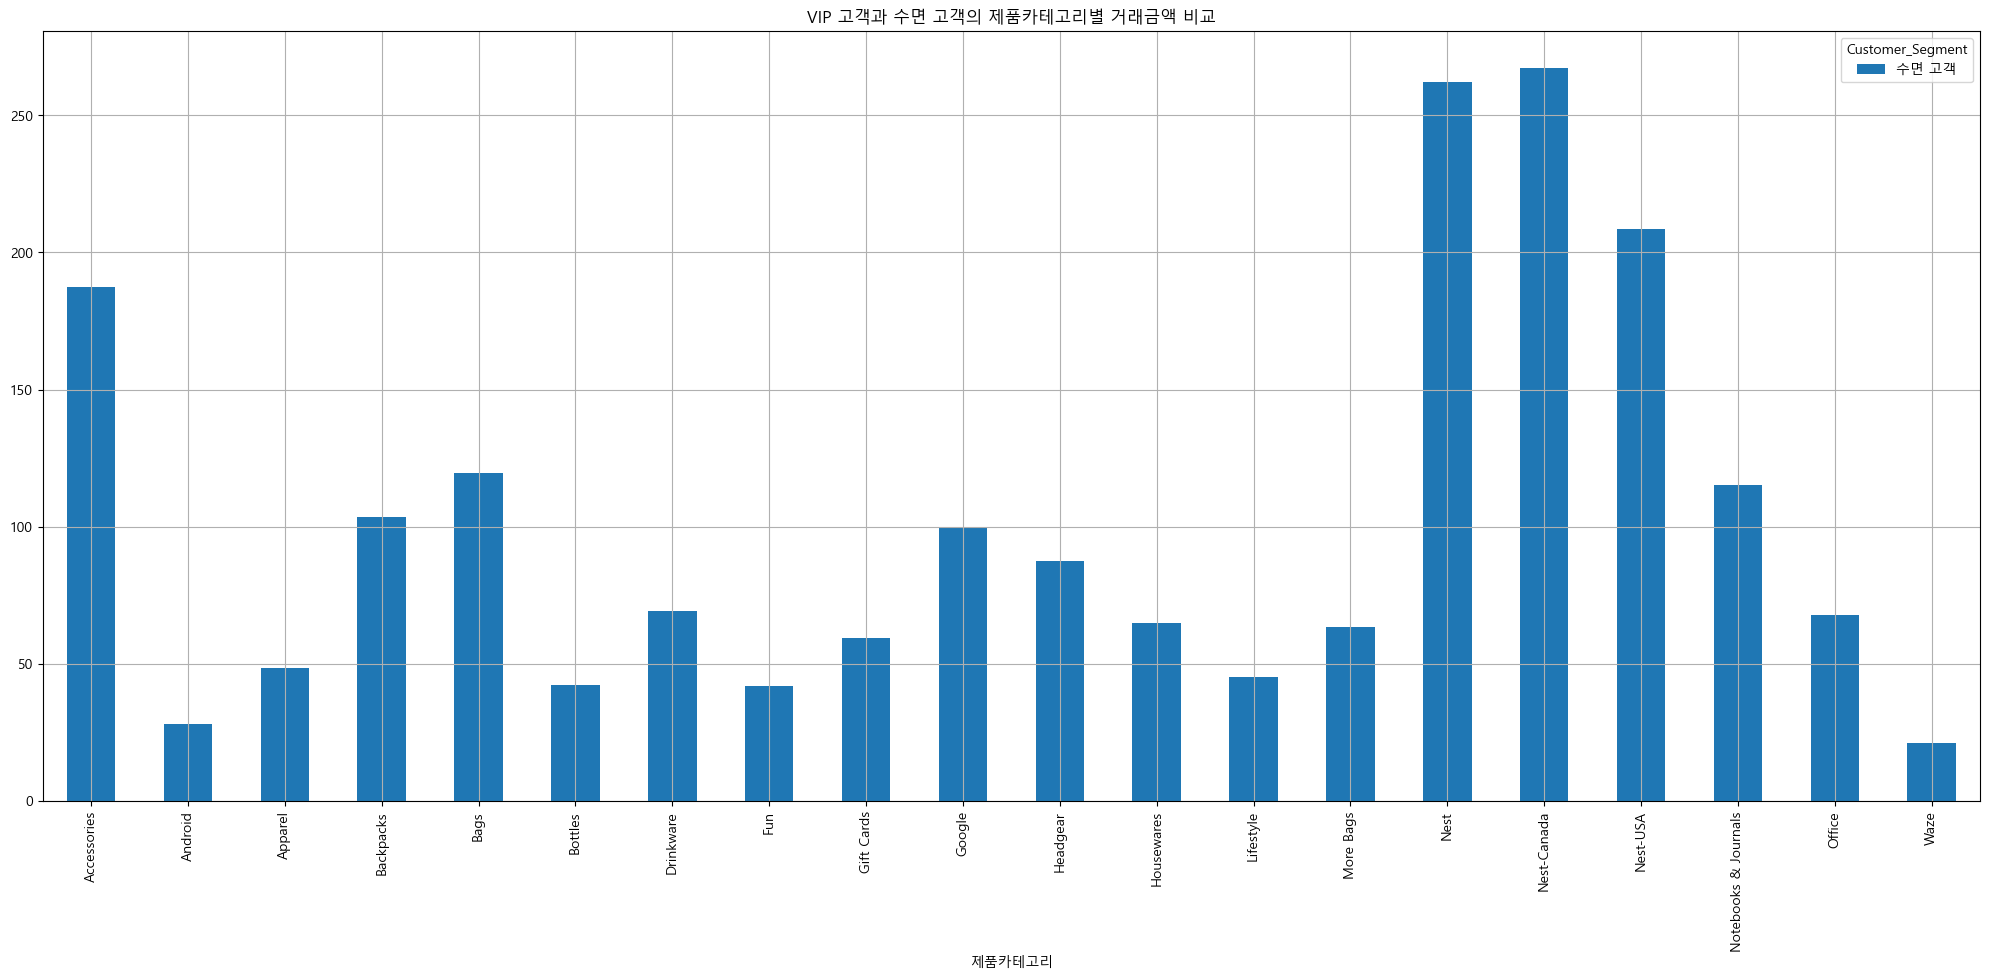

In [73]:
total_information_vip_plot = to_month(total_information, '거래날짜' )
total_information_vip_sleep_plot = pd.merge(total_information_vip_plot,rfm_kmean_merge, on = '고객ID' )

total_information_sleep_plot = total_information_vip_sleep_plot.loc[total_information_vip_sleep_plot['Customer_Segment']=='수면 고객']
pd.pivot_table(total_information_sleep_plot, columns = 'Customer_Segment', index = '제품카테고리', values = 'Total_Purchase_Amount', aggfunc='mean').plot(kind='bar')
plt.title('VIP 고객과 수면 고객의 제품카테고리별 거래금액 비교')
plt.grid()

### 수면 고객은 어떤 제품을 많이 샀었는가

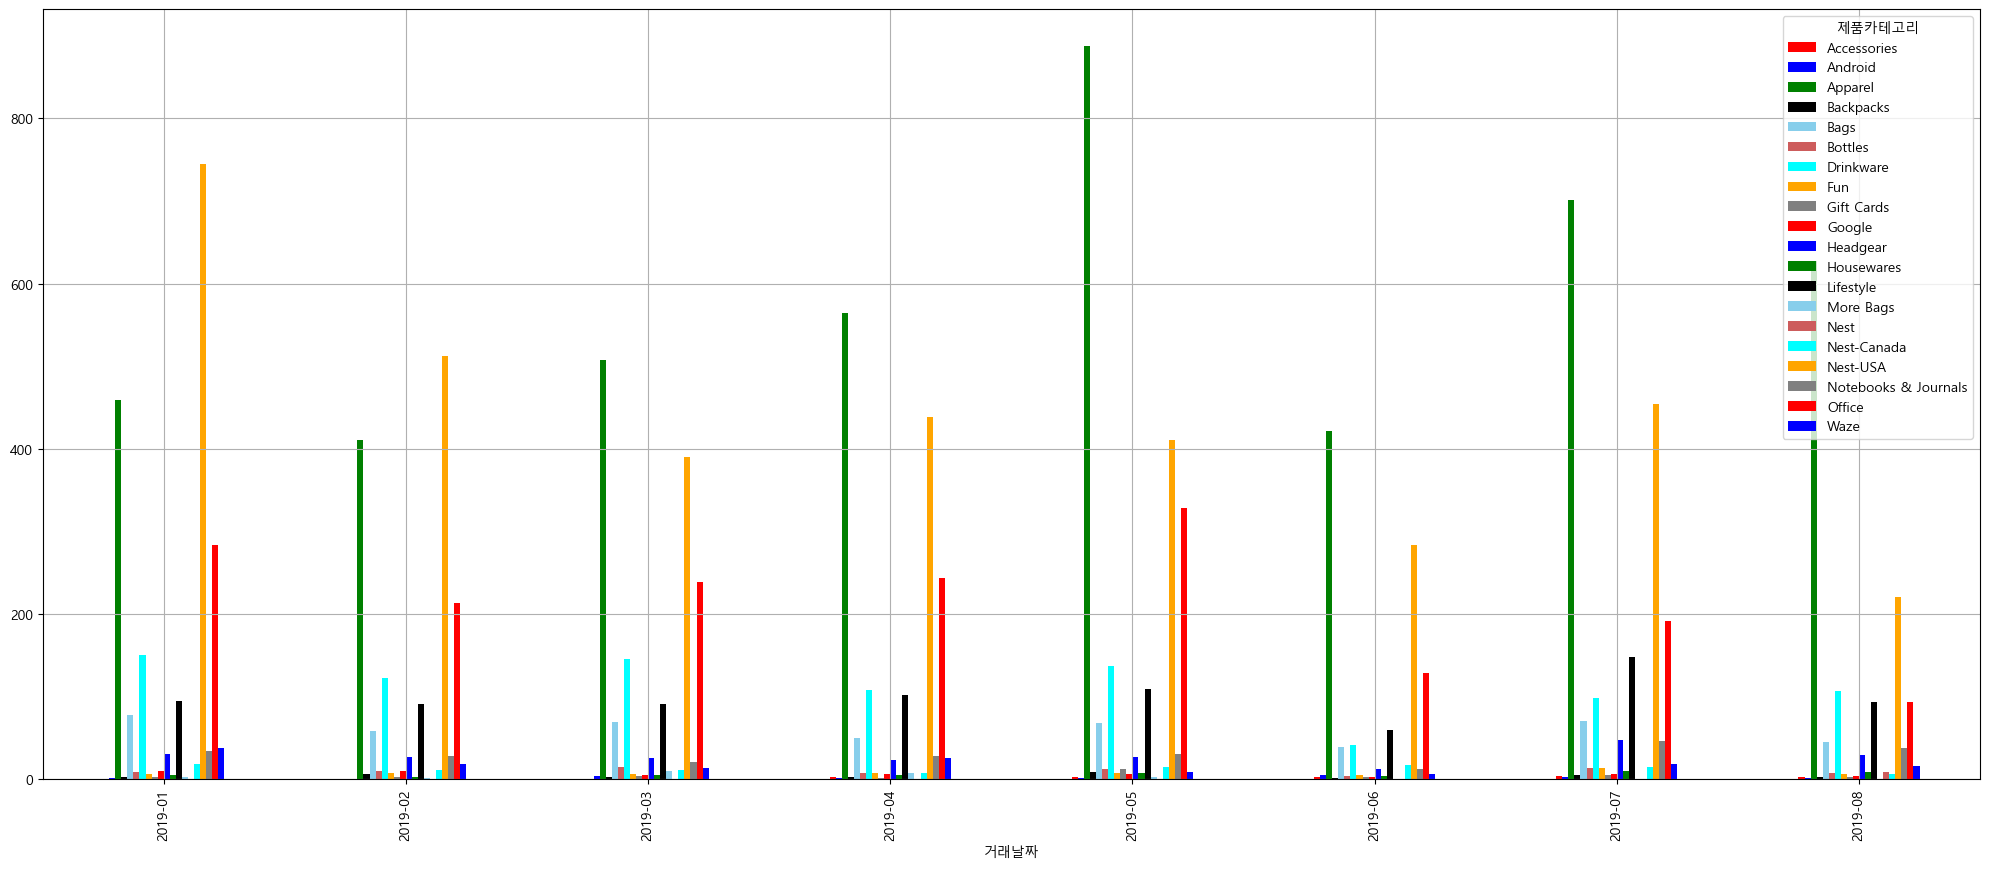

In [57]:
total_information_sleep_plot = to_month(total_information, '거래날짜' )
total_information_sleep_plot = pd.merge(total_information_vip_plot,rfm_kmean_merge, on = '고객ID' )
total_information_sleep_plot = total_information_sleep_plot.loc[total_information_sleep_plot['Customer_Segment']=='수면 고객']
total_information_sleep_plot
pd.pivot_table(total_information_sleep_plot, index = '거래날짜', columns ='제품카테고리', values = '수량', aggfunc='count').fillna(0).plot(kind='bar',
                                                                                                                                                color = ['Red', 'blue', 'Green', 'black', 'skyblue',
                                                                                                                                                        'indianred', 'cyan', 'orange', 'grey'])
plt.grid()

### 수면 고객은 어떤 제품에 돈을 많이 썼었는가?

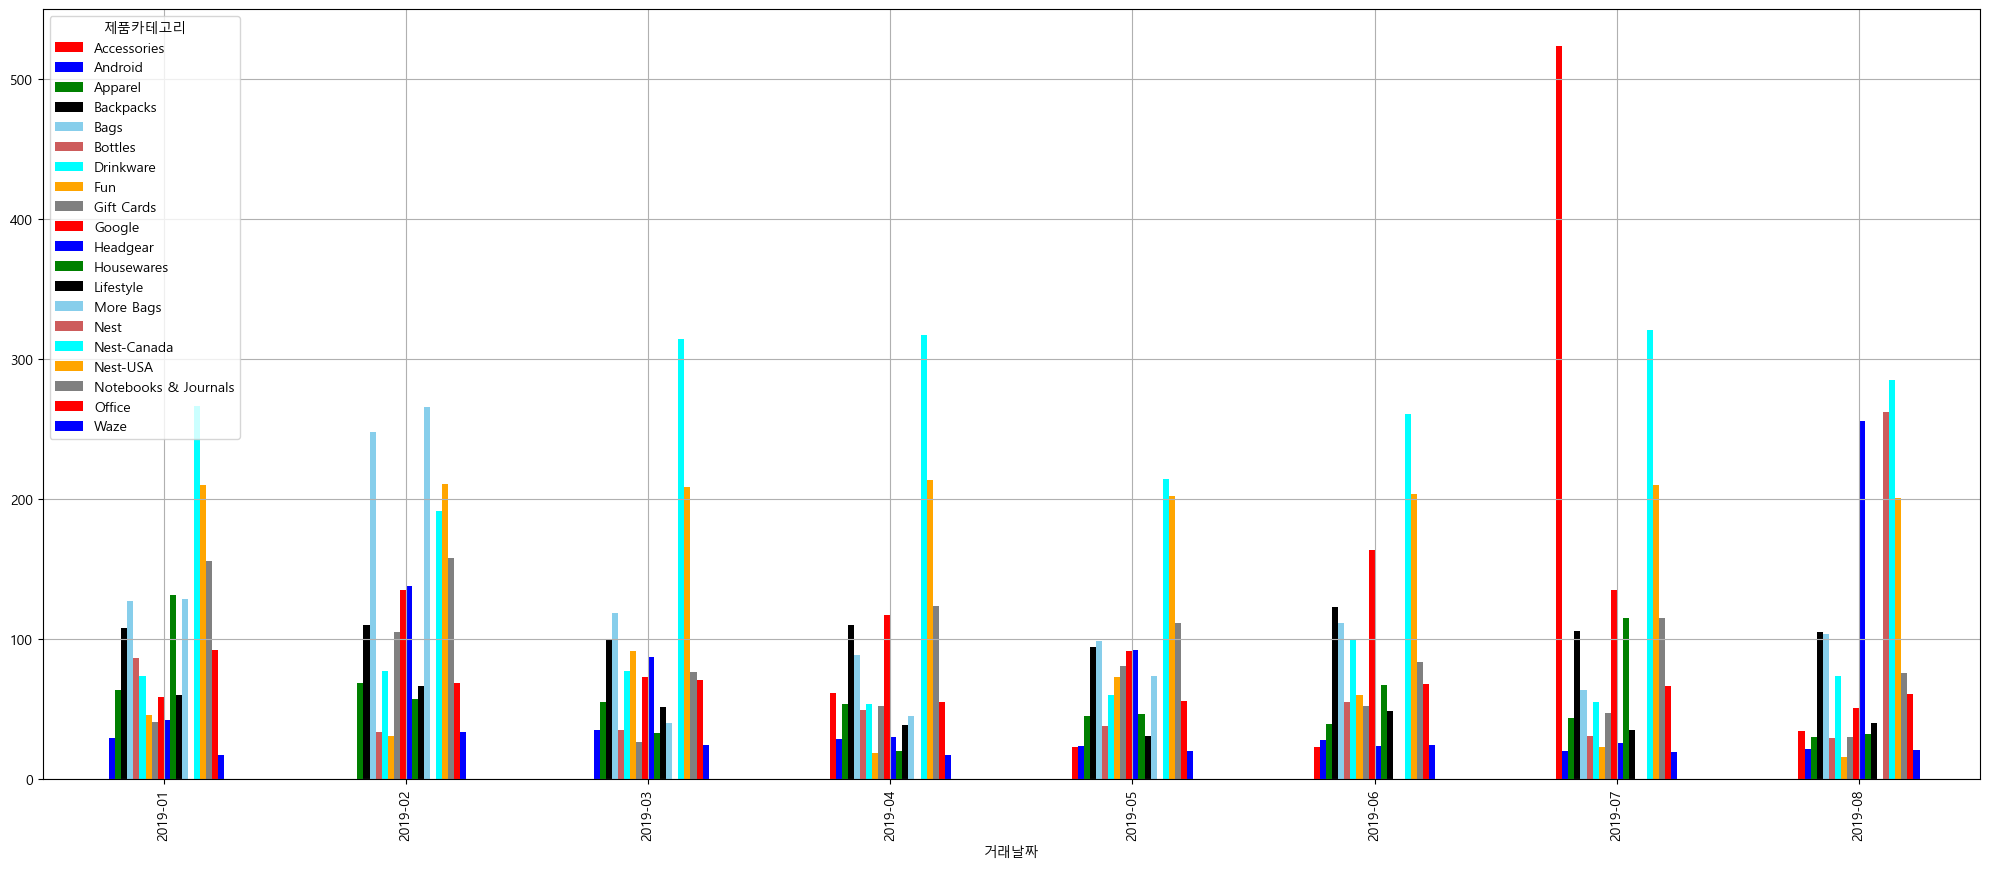

In [58]:
total_information_sleep_plot = to_month(total_information, '거래날짜' )
total_information_sleep_plot = pd.merge(total_information_vip_plot,rfm_kmean_merge, on = '고객ID' )
total_information_sleep_plot = total_information_sleep_plot.loc[total_information_sleep_plot['Customer_Segment']=='수면 고객']
total_information_sleep_plot
pd.pivot_table(total_information_sleep_plot, index = '거래날짜', columns ='제품카테고리', values = 'Total_Purchase_Amount', aggfunc='mean').fillna(0).plot(kind='bar',
                                                                                                                                                color = ['Red', 'blue', 'Green', 'black', 'skyblue',
                                                                                                                                                        'indianred', 'cyan', 'orange', 'grey'])
plt.grid()

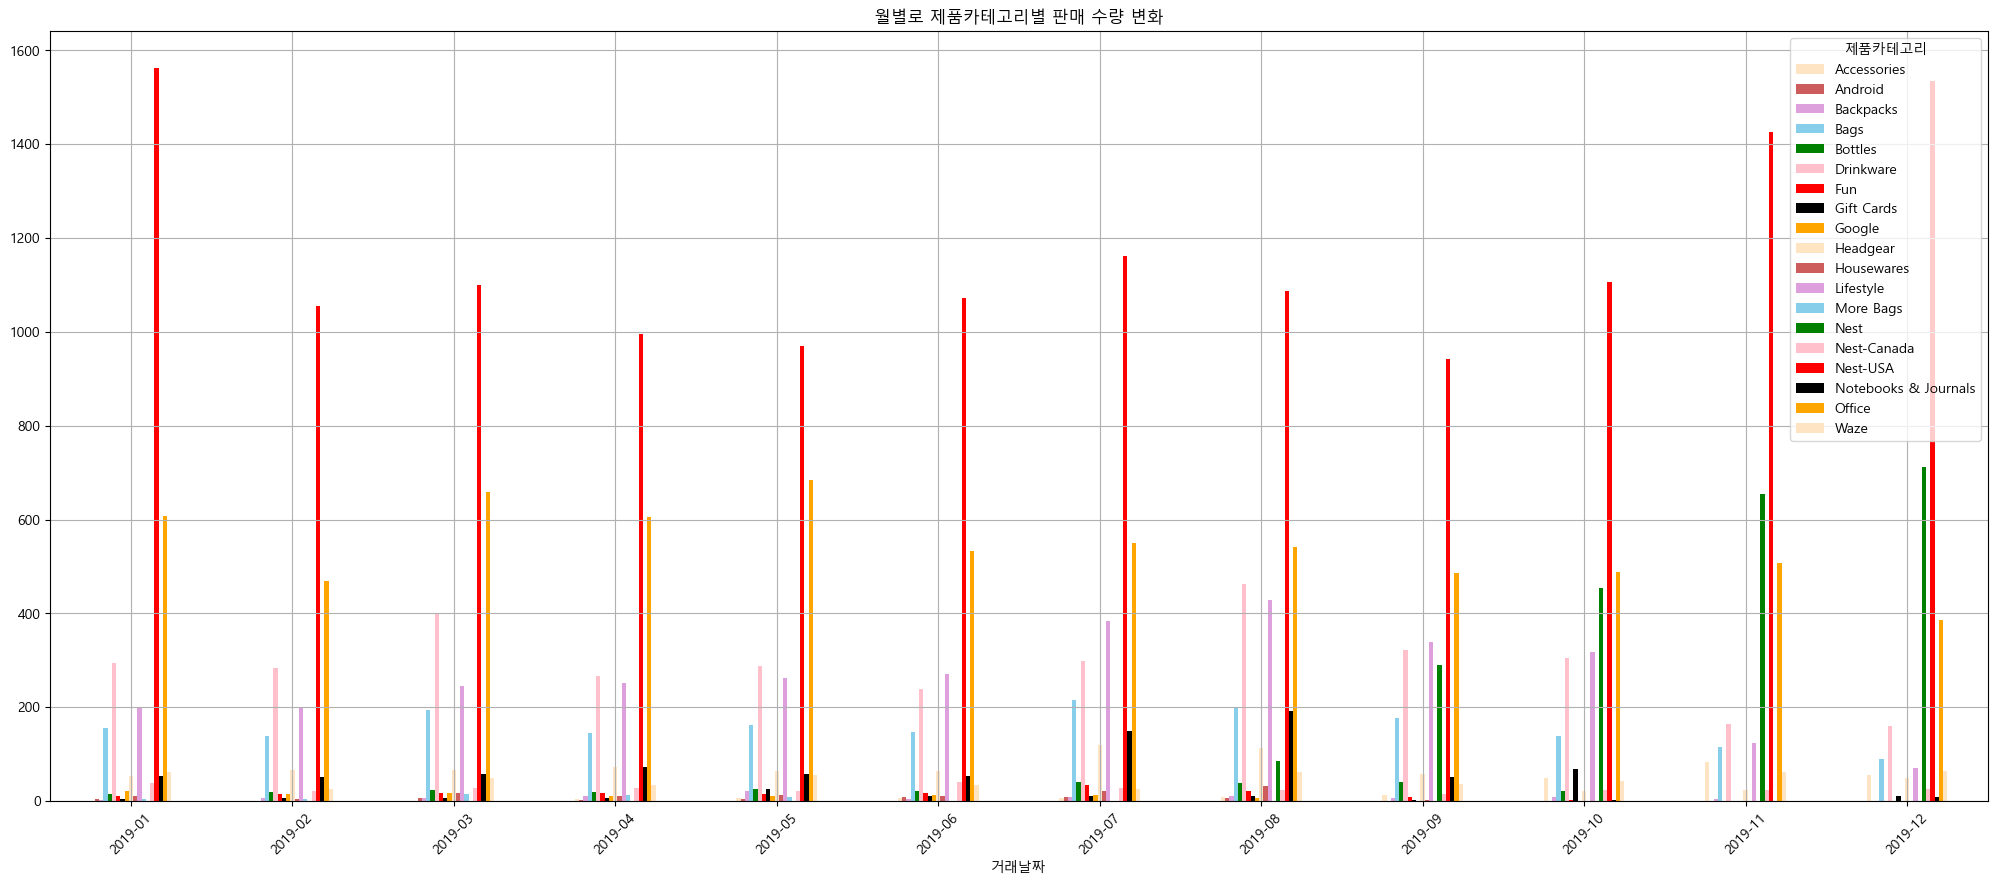

In [80]:
total_information_category = to_month(total_information, '거래날짜' )
total_information_category = pd.pivot_table(total_information_category, index = '거래날짜', columns = '제품카테고리', values = '수량', aggfunc='count')
total_information_category.fillna(0, inplace=True)
total_information_category.drop('Apparel', axis=1, inplace=True)
total_information_category.plot(kind='bar', color = ['bisque', 'indianred', 'plum', 'skyblue', 'green', 'pink', 'red', 'black', 'orange'])

plt.title('월별로 제품카테고리별 판매 수량 변화')
plt.grid()
plt.xticks(rotation=45)
plt.show()